In [5]:
"""
Title: Joplin Pyomo Multi-Objective Optimization Code
Code Author: Dale Cochran
Date Last Edited: 5/1/2020
Purpose: The purpose of this Python code file is to run a series of linear programming models for single- and 
         multi-objective optimization relating to the effect of extreme weather on a community in terms of 
         three objective functions. The three objectives used in this program are to minimize economic loss, 
         minimize population dislocation, and maximize building functionality.
"""
####################################################################################################
####################################################################################################
#IMPORT LIBRARIES:
####################################################################################################
####################################################################################################
import sys
import pandas as pd
import numpy as np
import csv
import time
import random
import matplotlib.pyplot as plt
from gurobipy import *  
import seaborn as sns
import math
from mpl_toolkits import mplot3d
import scipy.interpolate as interp
import collections
from matplotlib import cm
from matplotlib.collections import LineCollection
import matplotlib as mpl
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from pyomo.environ import *
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverManagerFactory
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
import plotly
import plotly.graph_objs as go
import matplotlib.patches as mpatches
import palettable.colorbrewer
import zipfile

In [6]:
####################################################################################################
####################################################################################################
#USER-DEFINED OPTIONS FOR RUNNING THE MODEL:
####################################################################################################
####################################################################################################
#Please read the comments below to understand how to change parameters of this code program.
####################################################################################################


####################################################################################################
#DECLARING THE SOLVER:
####################################################################################################
#Here you may choose which solver will be used throughout this program to optimize the variations of the model. 
  #This program's default is to use the open-source CBC solver engine via the NEOS Server solver manager (modelSolver=0). 
  #If you wish to use the open-source GLPK solver engine (Pyomo's solver engine), set the value of modelSolver to 1.
  #If you wish to use the Gurobi solver engine, set the value of modelSolver to 2.
modelSolver=0


####################################################################################################
#DECLARING THE NUMBER OF EPSILON VALUES TO EVALUATE:
####################################################################################################
#Here you may choose the number of epsilon values that will be evaluated for each run of the model containing a(n) epsilon constraint(s).
  #This program's default is to use 20 epsilon values.
  #This number will be applied to all of the model runs that include one or more epsilon constraints. 
  #This number of epsilon steps is inclusive of the minimum and maximum values of the respective epsilon range.
  #For example, if you set numEpsilonSteps to 10, where the minimum economic loss epsilon value is 1 and the maximum 
    #economic loss epsilon value is 10, and the minimum building functionality epsilon value is 0.1 and the maximum 
    #building functionality epsilon value is 1, then the epsilon values that will be evaluated for economic loss are 
    #[1,2,3,4,5,6,7,8,9,10] and the epsilon values that will be evaluated for building functionality are 
    #[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]. When the model is run to optimize population dislocation subject to 
    #economic loss and building functionality epsilon constraints it will be optimized 100 times, once for each 
    #combination of the 10 economic loss epsilon values and 10 building functionality epsilon values.
numEpsilonSteps=20


####################################################################################################
#DEFINING THE PARAMETERS OF THE BUDGET:
####################################################################################################
#Here you may choose how the budget is defined for the models in this program. 
  #This program's default is to define the maximum possible budget as the monetary amount that would be required to retrofit
    #every building to the best possible strategy level, and then define the available budget (the budget amount used to
    #constrain the model) as 20% of the maximum possible budget. 
    #To achieve this default setting, maxBudget is set to "default" and availBudget is set to 0.2. 
  #If you wish to use a different maximum possible budget, change the value of maxBudget to the desired monetary amount (as a number, not as a string).
    #If maxBudget is set to a value other than "default", then the program will not calculate the maximum possible budget as the 
      #monetary amount that would be required to retrofit every building to the best possible strategy level, but will 
      #instead use to provided value.
  #If you wish to use a different percentage for the available budget, change the value of availBudget to the desired
    #percentage value in decimal form. 
    #If you have an exact number for the monetary available budget, enter that number as the maxBudget value and set the
      #availBudget parameter equal to 1. 
maxBudget="default"
availBudget=0.2


####################################################################################################
#DETERMINING WHICH MODEL VARIATIONS TO RUN:
####################################################################################################
#Here you may choose which of the model variations in this program will be run and which will not be run. 
  #This program's default is to run all of the models in this program. 
  #runModel1 corresponds to the model for optimizing economic loss subject to population dislocation epsilon constraints. 
    #If you do not wish to run this model, set runModel1 equal to 0.
  #runModel2 corresponds to the model for optimizing economic loss subject to building functionality epsilon constraints.
    #If you do not wish to run this model, set runModel2 equal to 0.
  #runModel3 corresponds to the model for optimizing population dislocation subject to economic loss epsilon constraints.
    #If you do not wish to run this model, set runModel3 equal to 0.
  #runModel4 corresponds to the model for optimizing population dislocation subject to building functionality epsilon constraints.
    #If you do not wish to run this model, set runModel4 equal to 0.
  #runModel5 corresponds to the model for optimizing building functionality subject to economic loss epsilon constraints.
    #If you do not wish to run this model, set runModel5 equal to 0.
  #runModel6 corresponds to the model for optimizing building functionality subject to population dislocation epsilon constraints.
    #If you do not wish to run this model, set runModel6 equal to 0.
  #runModel7 correpsonds to the model for optimizing economic loss subject to population dislocation epsilon constraints
    #and building functionality epsilon constraints. 
    #If you do not wish to run this model, set runModel7 equal to 0.
  #runModel8 correpsonds to the model for optimizing population dislocation subject to economic loss epsilon constraints
    #and building functionality epsilon constraints. 
    #If you do not wish to run this model, set runModel8 equal to 0.
  #runModel9 correpsonds to the model for optimizing building functionality subject to economic loss epsilon constraints
    #and population dislocation epsilon constraints. 
    #If you do not wish to run this model, set runModel8 equal to 0.
  #If a model is not run, this program will not produce the plots related to the results of that given model.
runModel1=1
runModel2=1
runModel3=1
runModel4=1
runModel5=1
runModel6=1
runModel7=1
runModel8=1
runModel9=1


####################################################################################################
#DETERMINE WHETHER OR NOT TO SCALE MONETARY DATA BY 1,000,000:
####################################################################################################
#Here you may decide if you would like to scale the monetary data (data columns 'l' and 'Sc') by scaleQuantity.
    #This program's default is to scale the monetary data by dividing by 1,000,000 (scaleData=1, scaleQuantity=1000000). 
    #If you do not want this program to scale the monetary data, set scaleData equal to 0. 
    #If you would like this program to scale the monetary data by dividing it by a value other than 1,000,000, then
        #set the value of scaleQuantity to the desired value.
scaleData=1
scaleQuantity=1000000




####################################################################################################
#MAKE SURE USER-DEFINED OPTION VALUES ARE VALID:
####################################################################################################
#Check if modelSolver is a valid setting value:
if modelSolver!=0 and modelSolver!=1 and modelSolver!=2:
    print("ERROR: The value entered for the user-defined option modelSolver is not valid.")
    print("This program only recognizes the values 0, 1, and 2 as valid values of modelSolver.")
    sys.exit(0)

#Check if numEpsilonSteps is a valid integer value:
if isinstance(numEpsilonSteps,int)==False and numEpsilonSteps.is_integer()==False:
    print("ERROR: The value entered for the user-defined option numEpsilonSteps is not valid.")
    print("This program only recognizes integers (e.g., 2 or 2.0) as valid values of numEpsilonSteps.")
    sys.exit(0)

#Check if maxBudget is "default" or a valid numeric value:
if maxBudget!="default" and isinstance(maxBudget,int)==False and isinstance(maxBudget,float)==False:
    print("ERROR: The value entered for the user-defined option maxBudget is not valid.")
    print("This program only recognizes the string 'default' or numeric values as valid values of maxBudget.")
    sys.exit(0)

#Check if availBudget is a valid numeric value:
if (isinstance(availBudget,int)==False and isinstance(availBudget,float)==False) or (availBudget>1):
    print("ERROR: The value entered for the user-defined option availBudget is not valid.")
    print("This program only recognizes the numeric percentage values in decimal form as valid values of availBudget.")
    if (isinstance(availBudget,int) or isinstance(availBudget,float)) and (availBudget>1):
        print("The value of availBudget cannot be greater than 1 (i.e., cannot be greater than 100%).")
    sys.exit(0)

#Check if runModel options are set to valid values:
if runModel1!=1 and runModel1!=0:
    print("ERROR: The value entered for the user-defined option runModel1 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel1.")
    sys.exit(0)
if runModel2!=1 and runModel2!=0:
    print("ERROR: The value entered for the user-defined option runModel2 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel2.")
    sys.exit(0)
if runModel3!=1 and runModel3!=0:
    print("ERROR: The value entered for the user-defined option runModel3 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel3.")
    sys.exit(0)
if runModel4!=1 and runModel4!=0:
    print("ERROR: The value entered for the user-defined option runModel4 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel4.")
    sys.exit(0)
if runModel5!=1 and runModel5!=0:
    print("ERROR: The value entered for the user-defined option runModel5 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel5.")
    sys.exit(0)
if runModel6!=1 and runModel6!=0:
    print("ERROR: The value entered for the user-defined option runModel6 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel6.")
    sys.exit(0)
if runModel7!=1 and runModel7!=0:
    print("ERROR: The value entered for the user-defined option runModel7 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel7.")
    sys.exit(0)
if runModel8!=1 and runModel8!=0:
    print("ERROR: The value entered for the user-defined option runModel8 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel8.")
    sys.exit(0)
if runModel9!=1 and runModel9!=0:
    print("ERROR: The value entered for the user-defined option runModel9 is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of runModel9.")
    sys.exit(0)

#Check if scaleData option is set to a valid value:
if scaleData!=1 and scaleData!=0:
    print("ERROR: The value entered for the user-defined option scaleData is not valid.")
    print("This program only recognizes the numeric values 0 or 1 as valid values of scaleData.")
    sys.exit(0)

#Check if scaleQuantity option is set to a valid value:
if isinstance(scaleQuantity,int)==False and isinstance(scaleQuantity,float)==False:
    print("ERROR: The value entered for the user-defined option scaleQuantity is not valid.")
    print("This program only recognizes numeric values as valid values of scaleQuantity.")
    sys.exit(0)

In [8]:
####################################################################################################
#READ IN DATA:
####################################################################################################
#Load the data file into the myData dataframe:
    #This will be the core dataframe that will not be altered. For any data manipulations, copies of myData will be made first (e.g., myData2, myData3, ...).
myData=pd.read_csv("../../resilience_NC/Joplin/Joplin_dataset/Data_Q_t.csv")
myData=pd.DataFrame(myData)
myData=myData.drop(myData.columns[0],axis=1)


#Load the Sc data into the myData_Sc dataframe:
myData_Sc=pd.read_csv("../../resilience_NC/Joplin/Joplin_dataset/Data_Sc.csv")
myData_Sc=pd.DataFrame(myData_Sc)
myData_Sc=myData_Sc.drop(myData_Sc.columns[0],axis=1)


#View the data:
print("NOT SCALED DATA:")
print("'Q' Data DataFrame: ")
print(myData)
print("-----------------------------------------------------------------------------------")
print("'Sc' Data DataFrame: ")
print(myData_Sc)
print(" ")

#Scale the monetary data:
for i in range(len(myData)):
    myData.loc[i,"Z"]=str(myData.loc[i,"Z"])
    if scaleData==1:
        myData.loc[i,"l"]=myData.loc[i,"l"]/scaleQuantity
for i in range(len(myData_Sc)):
    myData_Sc.loc[i,"Z"]=str(myData_Sc.loc[i,"Z"])
    if scaleData==1:
        myData_Sc.loc[i,"Sc"]=myData_Sc.loc[i,"Sc"]/scaleQuantity

print("SCALED DATA:")
print("'Q' Data  DataFrame: ")
print(myData)
print("-----------------------------------------------------------------------------------")
print("'Sc' Data  DataFrame: ")
print(myData_Sc)

NOT SCALED DATA:
'Q' Data DataFrame: 
                    Z  S  K             l    b   Q_t_hat      d_ijk
0     290970101001000  1  0  21991.200000  5.0  0.000040   5.361238
1     290970101001000  1  1  21979.895000  0.0  0.000040   5.359580
2     290970101001000  1  2  14499.460970  0.0  0.000040   4.198795
3     290970101001000  1  3   4194.235076  0.0  0.000039   2.628615
4     290970101001001  1  0  17962.200000  2.0  0.000040   1.286697
...               ... .. ..           ...  ...       ...        ...
6223  291450206011013  1  3   7528.613054  0.0  0.000040   7.567904
6224  291450206011020  1  0  66633.200000  8.0  0.000040  26.897460
6225  291450206011020  1  1  66598.945930  0.0  0.000040  26.889821
6226  291450206011020  1  2  43933.277070  0.0  0.000038  21.444681
6227  291450206011020  1  3  12708.506340  0.0  0.000032  13.759826

[6228 rows x 7 columns]
-----------------------------------------------------------------------------------
'Sc' Data DataFrame: 
               

In [9]:
####################################################################################################
####################################################################################################
#DEFINE THE BASE MODEL AND OBTAIN EPSILON VALUES FOR MULTI-OBJECTIVE OPTIMIZATION:
####################################################################################################
####################################################################################################


####################################################################################################
#DEFINE THE MODEL:
####################################################################################################
"""
This code block creates the base model in Pyomo. This code block defines the model as a Pyomo concrete model,
    declares all of the sets that will be used in the model (e.g., for indexing), declares the decision variables, and
    declares the parameters for the model (e.g., number of buildings in neighborhood i of type j), and declares the 
    budget available for optimization as 20% of the ideal budget (budget needed to renovate every building to the 
    maximum strategy level). This code block then defines and declares the three respective base objective 
    functions (min economic loss, min dislocation, max functionality), and the three base constraints. 
Finally, this code block declares the solver engine for Pyomo to use. Pyomo is the solver/optimization platform in 
    which we code the model. However, Pyomo does the actual optimization through a specified solver engine 
    (e.g., can set the solver engine to cplex, gurobi, glpk, ipopt, etc...). This code uses 'glpk' as the solver engine
    which is open source and the default for Pyomo. 
"""
#Define the model:
model=ConcreteModel()


####################################################################################################
#DEFINE SETS FOR THE MODEL:
####################################################################################################
"""
In Pyomo, any 'list' that will be indexed through must be declared as a Pyomo set, and must also be initialized.
"""
#Define the model sets Z, S, and K:
model.Z=Set(initialize=myData.Z.unique()) #Set of all unique blockid numbers in the 'Z' column. 
model.S=Set(initialize=myData.S.unique()) #Set of all unique archtypes in the 'S' column. 
model.K=Set(initialize=myData.K.unique()) #Set of all unique numbers in the 'K' column. 
model.K_prime=Set(initialize=myData_Sc["K'"].unique()) #Set of all unique numbers in the 'K_prime' column.


#Define the set of all ZSK combinations:
zsk=[]
for y in range(len(myData)):
    i=myData.loc[y,'Z'] #Identify the i ∈ Z value.
    j=myData.loc[y,'S'] #Identify the j ∈ S value.
    k=myData.loc[y,'K'] #Identify the k ∈ K value.
    zsk.append((i,j,k)) #Add the combination to the list. 
zsk=sorted(set(zsk),key=zsk.index) #Convert the list to an ordered set for Pyomo.
model.ZSK=Set(initialize=zsk) #Define and initialize the ZSK set in Pyomo.


#Define the set of all ZS combinations:
zs=[]
for y in range(len(myData)):
    i=myData.loc[y,'Z'] #Identify the i ∈ Z value.
    j=myData.loc[y,'S'] #Identify the j ∈ S value.
    zs.append((i,j)) #Add the combination to the list. 
zs=sorted(set(zs),key=zs.index) #Convert the list to an ordered set for Pyomo.
model.ZS=Set(initialize=zs) #Define and initialize the ZS set in Pyomo. 


#Define the set of all KK' combinations:
kk_prime=[]
for y in range(len(myData_Sc)):
    k=myData_Sc.loc[y,'K'] #Identify the k ∈ K value.
    k_prime=myData_Sc.loc[y,"K'"] #Identify the k ∈ K value.
    kk_prime.append((k,k_prime)) #Add the combination to the list. 
kk_prime=sorted(set(kk_prime),key=kk_prime.index) #Convert the list to an ordered set for Pyomo.
model.KK_prime=Set(initialize=kk_prime) #Define and initialize the KK_prime set in Pyomo.


#Define the set of all K'K combinations:
k_primek=[]
for y in range(len(myData_Sc)):
    k=myData_Sc.loc[y,'K'] #Identify the k ∈ K value.
    k_prime=myData_Sc.loc[y,"K'"] #Identify the k ∈ K value.
    if k_prime<=k:
        k_primek.append((k_prime,k)) #Add the combination to the list. 
k_primek=sorted(set(k_primek),key=k_primek.index) #Convert the list to an ordered set for Pyomo.
model.K_primeK=Set(initialize=k_primek) #Define and initialize the K_primeK set in Pyomo.


#Define the set of all ZSKK' combinations:
zskk_prime=[]
for y in range(len(myData_Sc)):
    i=myData_Sc.loc[y,'Z'] #Identify the i ∈ Z value.
    j=myData_Sc.loc[y,'S'] #Identify the j ∈ S value.
    k=myData_Sc.loc[y,'K'] #Identify the k ∈ K value.
    k_prime=myData_Sc.loc[y,"K'"] #Identify the k ∈ K value.
    zskk_prime.append((i,j,k,k_prime)) #Add the combination to the list. 
zskk_prime=sorted(set(zskk_prime),key=zskk_prime.index) #Convert the list to an ordered set for Pyomo.
model.ZSKK_prime=Set(initialize=zskk_prime) #Define and initialize the ZSKK_prime set in Pyomo.

####################################################################################################
#DEFINE VARIABLES AND PARAMETERS:
####################################################################################################
#Declare the decision variable x_ijk (total # buildings in zone i of structure type j at code level k after retrofitting):
model.x_ijk=Var(model.ZSK,within=NonNegativeReals)


#Declare the decision variable y_ijkk_prime (total # buildings in zone i of structure type j retrofitted from code level k to code level k_prime):
model.y_ijkk_prime=Var(model.ZSKK_prime,within=NonNegativeReals)


#Declare economic loss cost parameter l_ijk:
model.l_ijk=Param(model.ZSK,within=NonNegativeReals,mutable=True)
for y in range(len(myData)):
    i=myData.loc[y,'Z']
    j=myData.loc[y,'S']
    k=myData.loc[y,'K']
    model.l_ijk[i,j,k]=myData.loc[y,'l']


#Declare dislocation parameter d_ijk:
model.d_ijk=Param(model.ZSK,mutable=True)
for y in range(len(myData)):
    i=myData.loc[y,'Z']
    j=myData.loc[y,'S']
    k=myData.loc[y,'K']
    model.d_ijk[i,j,k]=myData.loc[y,'d_ijk']
    

#Declare the number of buildings parameter b_ijk:
model.b_ijk=Param(model.ZSK,mutable=True)
for y in range(len(myData)):
    i=myData.loc[y,'Z']
    j=myData.loc[y,'S']
    k=myData.loc[y,'K']
    model.b_ijk[i,j,k]=myData.loc[y,'b']


#Declare the building functionality parameter Q_t_hat:
model.Q_t_hat=Param(model.ZSK,mutable=True)
for y in range(len(myData)):
    i=myData.loc[y,'Z']
    j=myData.loc[y,'S']
    k=myData.loc[y,'K']
    model.Q_t_hat[i,j,k]=myData.loc[y,'Q_t_hat']


#Declare the retrofit cost parameter Sc_ijkk':
model.Sc_ijkk_prime=Param(model.ZSKK_prime,mutable=True)
for y in range(len(myData_Sc)):
    i=myData_Sc.loc[y,'Z']
    j=myData_Sc.loc[y,'S']
    k=myData_Sc.loc[y,'K']
    k_prime=myData_Sc.loc[y,"K'"]
    model.Sc_ijkk_prime[i,j,k,k_prime]=myData_Sc.loc[y,'Sc']


####################################################################################################
#DECLARE THE TOTAL MAX BUDGET AND TOTAL AVAILABLE BUDGET:
####################################################################################################
#Define the total max budget based on user's input:
model.B=Param(mutable=True,within=NonNegativeReals)
if maxBudget=="default":
    sumSc=quicksum(pyo.value(model.Sc_ijkk_prime[i,j,k,3])*pyo.value(model.b_ijk[i,j,k]) for i,j,k in model.ZSK)
else:
    sumSc=maxBudget
#Define the total available budget based on user's input:
model.B=sumSc*availBudget


####################################################################################################
#OBJECTIVE FUNCTIONS:
####################################################################################################
#Objective function 1 - direct economic loss:       ### EQUATION 12 ###
def obj_economic(model):
    #return(sum_product(model.l_ijk,model.x_ijk))
    return(quicksum(model.l_ijk[i,j,k]*model.x_ijk[i,j,k] for (i,j,k) in model.ZSK))
model.objective_1=Objective(rule=obj_economic,sense=minimize)
#Parameter to store economic loss value:
model.econ_loss=Param(mutable=True,within=NonNegativeReals)#,default=10000000000)


#Objective function 2 - population dislocation:          ### EQUATION 13 ###
def obj_dislocation(model):
    #return(sum_product(model.d_ijk,model.x_ijk))
    return(quicksum(model.d_ijk[i,j,k]*model.x_ijk[i,j,k] for (i,j,k) in model.ZSK))
model.objective_2=Objective(rule=obj_dislocation,sense=minimize)
#Parameter to store dislocation value:
model.dislocation=Param(mutable=True,within=NonNegativeReals)#,default=30000)


#Objective function 3 - functionality:           ### EQUATION 14 ###
def obj_functionality(model):
    #return(sum_product(model.Q_t_hat,model.x_ijk))
    return(quicksum(model.Q_t_hat[i,j,k]*model.x_ijk[i,j,k] for (i,j,k) in model.ZSK))
model.objective_3=Objective(rule=obj_functionality,sense=maximize)
#Parameter to store functionality value:
model.functionality=Param(mutable=True,within=NonNegativeReals)#,default=1)


####################################################################################################
#CONSTRAINTS:
####################################################################################################
print("Creating constraints for total cost of retrofit actions.")
#Retrofit budget constraint:
def retrofit_cost_rule(model):      ### EQUATION 21 ###
    return(None,
           quicksum(model.Sc_ijkk_prime[i,j,k,k_prime]*model.y_ijkk_prime[i,j,k,k_prime] for (i,j,k,k_prime) in model.ZSKK_prime),#zskk_prime),
           pyo.value(model.B))
model.retrofit_budget_constraint=Constraint(rule=retrofit_cost_rule)


#Total number of building type j in zone i constraint:       ### EQUATION 23 ###
print("Creating constraints for number of buildings consistency.")
def number_buildings_ij_rule(model,i,j):
    return(quicksum(pyo.value(model.b_ijk[i,j,k]) for k in model.K),
          quicksum(model.x_ijk[i,j,k] for k in model.K),
          quicksum(pyo.value(model.b_ijk[i,j,k]) for k in model.K))
        #(sum(pyo.value(model.b_ijk[i,j,k]) for k in model.K) == sum(pyo.value(model.b_ijk[i,j,k]) for k in model.K) for (i,j) in model.ZS))
model.number_buildings_ij_constraint=Constraint(model.ZS,rule=number_buildings_ij_rule)


#Building level change constraint:
print("Creating constraints for building strategy level flow balance.")
model.a=Param(mutable=True) #Parameter to hold the value of y_ijkk_prime[i,j,k_prime,k] for the building level constraint (Equation 22).
model.c=Param(mutable=True) #Parameter to hold the value of y_ijkk_prime[i,j,k,k_prime] for the building level constraint (Equation 22).

def building_level_rule(model,i,j,k):
    model.a=quicksum(model.y_ijkk_prime[i,j,k_prime,k] for k_prime in model.K_prime if (i,j,k_prime,k) in zskk_prime) #model.ZSKK_prime
    model.c=quicksum(model.y_ijkk_prime[i,j,k,k_prime] for k_prime in model.K_prime if (i,j,k,k_prime) in zskk_prime) #model.ZSKK_prime
    return(pyo.value(model.b_ijk[i,j,k]),          #### EQUATION 22 ###
           model.x_ijk[i,j,k]+quicksum(model.y_ijkk_prime[i,j,k,k_prime] for k_prime in model.K_prime if (i,j,k,k_prime) in zskk_prime)-quicksum(model.y_ijkk_prime[i,j,k_prime,k] for k_prime in model.K_prime if (i,j,k_prime,k) in zskk_prime),
           pyo.value(model.b_ijk[i,j,k]))
model.building_level_constraint=Constraint(model.ZSK,rule=building_level_rule)


####################################################################################################
#DEFINE SOLVER THE MODEL:
####################################################################################################
#Set solver and solver manager:
if modelSolver==0:
    modelSolverSetting=pyo.SolverManagerFactory('neos')
elif modelSolver==1:
    modelSolverSetting=pyo.SolverFactory('glpk')
elif modelSolver==2:
    modelSolverSetting=pyo.SolverFactory('gurobi')





####################################################################################################
#SOLVE THE MODEL FOR EACH RESPECTIVE OBJECTIVE FUNCTION WITHOUT EPSILON CONSTRAINTS:
####################################################################################################
#     AND IDENTIFY MINIMUM AND MAXIMUM EPSILON VALUES FOR EACH OBJECTIVE:
####################################################################################################
"""
In Pyomo declared objectives can be activated and deactivated. Activated objective functions are what Pyomo will 
    optimize, while the other deactivated objective functions will be ignored. For example, when objective function 1 is
    activated and objective functions 2 and 3 are deactivated, Pyomo will find the optimal solution that minimizes 
    economic loss. 
"""
####################################################################################################
#SOLVE FOR OBJECTIVE FUNCTION 1 ONLY:
####################################################################################################
starttime=time.time()
print("Initial solve for objective function 1 starting.")
#Activate objective function 1 (minimize economic loss) and deactivate others:
model.objective_1.activate()
model.objective_2.deactivate()
model.objective_3.deactivate()

#Solve the model:
if modelSolver==0:
    results=modelSolverSetting.solve(model,opt='cbc')
else:
    results=modelSolverSetting.solve(model)
#Save the results if the solver returns an optimal solution:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
    model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
    model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
    obj_1_min_epsilon=pyo.value(model.objective_1) #Save the optimal economic loss value.
    obj_2_value_1=pyo.value(model.dislocation) #Save the dislocation value when optimizing economic loss. 
    obj_3_value_1=pyo.value(model.functionality) #Save the functionality value when optimizing economic loss.
    print("Initial solve for objective function 1 complete.")
    print("Economic Loss: ",pyo.value(model.econ_loss),
      "Dislocation: ",pyo.value(model.dislocation),
      "Functionality: ",pyo.value(model.functionality))
else:
    print("Not Optimal")

endtime=time.time()
elapsedtime=endtime-starttime
print("Elapsed time for initial obj 1 solve: ",elapsedtime)
print("")


####################################################################################################
#SOLVE FOR OBJECTIVE FUNCTION 2 ONLY:
####################################################################################################
starttime=time.time()
print("Initial solve for objective function 2 starting.")
#Activate objective function 2 (minimize dislocation) and deactivate others:
model.objective_1.deactivate()
model.objective_2.activate()
model.objective_3.deactivate()

#Solve the model:
if modelSolver==0:
    results=modelSolverSetting.solve(model,opt='cbc')
else:
    results=modelSolverSetting.solve(model)
#Save the results if the solver returns an optimal solution:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
    model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
    model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
    obj_2_min_epsilon=pyo.value(model.objective_2) #Save the optimal dislocation value.
    obj_1_value_2=pyo.value(model.econ_loss) #Save the economic loss value when optimizing dislocation.
    obj_3_value_2=pyo.value(model.functionality) #Save the functionality value when optimizing dislocation.
    print("Initial solve for objective function 2 complete.")
    print("Economic Loss: ",pyo.value(model.econ_loss),
      "Dislocation: ",pyo.value(model.dislocation),
      "Functionality: ",pyo.value(model.functionality))
else:
    print("Not Optimal")

endtime=time.time()
elapsedtime=endtime-starttime
print("Elapsed time for initial obj 2 solve: ",elapsedtime)
print("")


####################################################################################################
#SOLVE FOR OBJECTIVE FUNCTION 3 ONLY:
####################################################################################################
starttime=time.time()
print("Initial solve for objective function 3 starting.")
#Activate objective function 3 (maximize functionality) and deactivate others:
model.objective_1.deactivate()
model.objective_2.deactivate()
model.objective_3.activate()

#Solve the model:
if modelSolver==0:
    results=modelSolverSetting.solve(model,opt='cbc')
else:
    results=modelSolverSetting.solve(model)
#Save the results if the solver returns an optimal solution:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
    model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
    model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
    obj_3_max_epsilon=pyo.value(model.objective_3) #Save the optimal functionality value.
    obj_1_value_3=pyo.value(model.econ_loss) #Save the economic loss value when optimizing functionality.
    obj_2_value_3=pyo.value(model.dislocation) #Save the dislocation value when optimizing functionality. 
    print("Initial solve for objective function 3 complete.")
    print("Economic Loss: ",pyo.value(model.econ_loss),
      "Dislocation: ",pyo.value(model.dislocation),
      "Functionality: ",pyo.value(model.functionality))
else:
    print("Not Optimal")

endtime=time.time()
elapsedtime=endtime-starttime
print("Elapsed time for initial obj 3 solve: ",elapsedtime)



####################################################################################################
#VIEW RESULTS FOR EACH OBJECTIVE FUNCTION:
####################################################################################################
print("Max Budget: $",sumSc)
print("Available Budget: $",pyo.value(model.B))
print("")

print("Economic loss min epsilon (optimal value):",obj_1_min_epsilon)
print("Dislocation when optimizing Economic Loss:",obj_2_value_1)
print("Functionality when optimizing Economic Loss:",obj_3_value_1)
print("")

print("Dislocation min epsilon (optimal value):",obj_2_min_epsilon)
print("Economic Loss when optimizing Dislocation:",obj_1_value_2)
print("Functionality when optimizing Dislocation:",obj_3_value_2)
print("")

print("Functionality max epsilon (optimal value):",obj_3_max_epsilon)
print("Economic Loss when optimizing Functionality:",obj_1_value_3)
print("Dislocation when optimizing Functionality:",obj_2_value_3)
#Save the initial results to a csv file:
no_epsilon_constr_init_results=pd.DataFrame(data={"Label":["Max Budget: $","Budget (20% of max)","Economic loss min epsilon (optimal value)","Dislocation when optimizing Economic Loss","Functionality when optimizing Economic Loss","Dislocation min epsilon (optimal value)","Economic Loss when optimizing Dislocation","Functionality when optimizing Dislocation","Functionality max epsilon (optimal value)","Economic Loss when optimizing Functionality","Dislocation when optimizing Functionality"]
,"Value":[sumSc,pyo.value(model.B),obj_1_min_epsilon,obj_2_value_1,obj_3_value_1,obj_2_min_epsilon,obj_1_value_2,obj_3_value_2,obj_3_max_epsilon,obj_1_value_3,obj_2_value_3]})
filename='no_epsilon_constr_init_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
no_epsilon_constr_init_results.to_csv(filename)




####################################################################################################
#DEFINE THE FEASIBLE RANGE (EPSILON VALUES):
####################################################################################################
"""
The minimum economic loss epsilon value is obtained from optimizing objective function 1 without any epsilon constraints. 
The maximum economic loss epsilon value is the largest economic loss value that resulted between when objective 
    function 2 (dislocation) was solved without any epsilon constraints and when objective function 3 (functionality) 
    was solved without any epsilon constraints. 
The minimum dislocation epsilon value is obtained from optimizing objective function 2 without any epsilon constraints. 
The maximum dislocation epsilon value is the largest dislocation value that resulted between when objective 
    function 1 (economic loss) was solved without any epsilon constraints and when objective function 3 (functionality) 
    was solved without any epsilon constraints. 
The maximum functionality epsilon value is obtained from optimizing objective function 3 without any epsilon constraints. 
The minimum functionality epsilon value is the smallest functionality value that resulted between when objective 
    function 1 (economic loss) was solved without any epsilon constraints and when objective function 2 (dislocation) 
    was solved without any epsilon constraints. 
"""

#Model parameters for the maximum and minimum epsilon values:
model.econ_loss_max=Param(within=NonNegativeReals,initialize=max(obj_1_value_2,obj_1_value_3)) #Maximum Economic Loss epsilon value.
model.econ_loss_min=Param(within=NonNegativeReals,initialize=obj_1_min_epsilon) #Minimum Economic Loss epsilon value.
model.dislocation_max=Param(within=NonNegativeReals,initialize=max(obj_2_value_1,obj_2_value_3)) #Maximum Dislocation epsilon value.
model.dislocation_min=Param(within=NonNegativeReals,initialize=obj_2_min_epsilon) #Minimum Dislocation epsilon value.
model.functionality_max=Param(within=NonNegativeReals,initialize=obj_3_max_epsilon) #Maximum Functionality epsilon value.
model.functionality_min=Param(within=NonNegativeReals,initialize=min(obj_3_value_1,obj_3_value_2)) #Minimum Functionality epsilon value.

#View epsilon range for each objective function:
print("Objective 1 max epsilon:",pyo.value(model.econ_loss_max))
print("Objective 1 min epsilon:",pyo.value(model.econ_loss_min))
print("")

print("Objective 2 max epsilon:",pyo.value(model.dislocation_max))
print("Objective 2 min epsilon:",pyo.value(model.dislocation_min))
print("")

print("Objective 3 max epsilon:",pyo.value(model.functionality_max))
print("Objective 3 min epsilon:",pyo.value(model.functionality_min))

#Define step size for epsilon values for each objective:
model.econ_loss_step=Param(within=NonNegativeReals,initialize=(pyo.value(model.econ_loss_max)-pyo.value(model.econ_loss_min))*(1/(numEpsilonSteps-1)))
model.dislocation_step=Param(within=NonNegativeReals,initialize=(pyo.value(model.dislocation_max)-pyo.value(model.dislocation_min))*(1/(numEpsilonSteps-1)))
model.functionality_step=Param(within=NonNegativeReals,initialize=(pyo.value(model.functionality_max)-pyo.value(model.functionality_min))*(1/(numEpsilonSteps-1)))



Creating constraints for total cost of retrofit actions.
Creating constraints for number of buildings consistency.
Creating constraints for building strategy level flow balance.
Initial solve for objective function 1 starting.


RuntimeError: NEOS requires a valid email address. Please set the 'NEOS_EMAIL' environment variable.

In [12]:
####################################################################################################
####################################################################################################
#RUN PYOMO MODELS WITH EPSILON CONSTRAINTS:
####################################################################################################
####################################################################################################


####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 1 WITH OBJECTIVE FUNCTION 2 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel1==1:
    starttime=time.time()
    print("****OPTIMIZING ECONOMIC LOSS SUBJECT TO POPULATION DISLOCATION EPSILON CONSTRAINTS****")
    #Activate objective function 1 and deactivate others:
    model.objective_1.activate()
    model.objective_2.deactivate()
    model.objective_3.deactivate()

    #Add objective function 2 as epsilon constraint of objective function 1:
    #Dataframe to store optimization results:
    obj_1_2_epsilon_results=pd.DataFrame(data={'Dislocation Epsilon':np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)),
                                               'Econ Loss Results':np.nan,'Dislocation Value':np.nan,
                                               'Functionality Value':np.nan})

    #Parameter for objective 2 (dislocation) epsilon value:
    model.obj_2_e=Param(mutable=True,within=NonNegativeReals)
    #For each dislocation epsilon value (starting at min) set as constraint and solve model:
    counter=0
    for e in np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)):
        counter+=1
        print("Step ",counter,": ",e)
    
        model.obj_2_e=e #Set the model parameter to the epsilon value.
        model.add_component("objective_2_constraint",
                            Constraint(expr=sum_product(model.d_ijk,model.x_ijk)<=pyo.value(model.obj_2_e))) #Add the epsilon constraint.
        #Solve the model:
        if modelSolver==0:
            results=modelSolverSetting.solve(model,opt='cbc')
        else:
            results=modelSolverSetting.solve(model)
        #Save the results if the solver returns an optimal solution:
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
            model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
            model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
            #Add objective (economic loss), dislocation, and functionality values to results dataframe:
            obj_1_2_epsilon_results.loc[counter-1,'Econ Loss Results']=pyo.value(model.econ_loss) #Save the optimal economic loss value.
            obj_1_2_epsilon_results.loc[counter-1,'Dislocation Value']=pyo.value(model.dislocation) #Save the resulting dislocation value.
            obj_1_2_epsilon_results.loc[counter-1,'Functionality Value']=pyo.value(model.functionality) #Save the resulting functionality value.
        else:
            print(results.solver.termination_condition)
            log_infeasible_constraints(model)

    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_2_constraint)

    #Remove the dislocation epsilon parameter from the model:
    model.del_component(model.obj_2_e)

    #Display and save the results of optimizing economic loss subject to dislocation epsilon constraints:
    print(obj_1_2_epsilon_results)
    filename='obj_1_2_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_1_2_epsilon_results.to_csv(filename)
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 1 WITH OBJECTIVE FUNCTION 3 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel2==1:
    starttime=time.time()
    print("****OPTIMIZING ECONOMIC LOSS SUBJECT TO BUILDING FUNCTIONALITY EPSILON CONSTRAINTS****")
    #Activate objective function 1 and deactivate others:
    model.objective_1.activate()
    model.objective_2.deactivate()
    model.objective_3.deactivate()
    
    #Add objective function 3 as epsilon constraint of objective function 1:
    #Dataframe to store optimization results:
    obj_1_3_epsilon_results=pd.DataFrame(data={'Functionality Epsilon':np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)),
                                               'Econ Loss Results':np.nan,'Dislocation Value':np.nan,
                                               'Functionality Value':np.nan})
    
    #Parameter for objective 3 (functionality) epsilon value:
    model.obj_3_e=Param(mutable=True,within=NonNegativeReals)
    counter=0
    #For each functionality epsilon value (starting at min) set as constraint and solve model:
        #Adding 0.0000000000001 to the maximum value allows np.arange() to include the maximum functionality.
    for e in np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.000000000000000001,pyo.value(model.functionality_step)):
        counter+=1
        print("Step ",counter,": ",e)
        
        model.obj_3_e=e #Set the model parameter to the epsilon value.
        model.add_component("objective_3_constraint",
                            Constraint(expr=sum_product(model.Q_t_hat,model.x_ijk)>=pyo.value(model.obj_3_e))) #Add the epsilon constraint.
        #Solve the model:
        if modelSolver==0:
            results=modelSolverSetting.solve(model,opt='cbc')
        else:
            results=modelSolverSetting.solve(model)
        #Save the results if the solver returns an optimal solution:
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
            model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
            model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
            #Add objective (economic loss), dislocation, and functionality values to results dataframe:
            obj_1_3_epsilon_results.loc[counter-1,'Econ Loss Results']=pyo.value(model.econ_loss) #Save the optimal economic loss value.
            obj_1_3_epsilon_results.loc[counter-1,'Dislocation Value']=pyo.value(model.dislocation) #Save the resulting dislocation value.
            obj_1_3_epsilon_results.loc[counter-1,'Functionality Value']=pyo.value(model.functionality) #Save the resulting functionality value.
        else:
            print(results.solver.termination_condition)
            log_infeasible_constraints(model)
    
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_3_constraint)
    
    #Remove the functionality epsilon parameter from the model:
    model.del_component(model.obj_3_e)
    
    #Display and save the results of optimizing economic loss subject to functionality epsilon constraints:
    print(obj_1_3_epsilon_results)
    filename='obj_1_3_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_1_3_epsilon_results.to_csv(filename)
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 2 WITH OBJECTIVE FUNCTION 1 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel3==1:
    starttime=time.time()
    print("****OPTIMIZING POPULATION DISLOCATION SUBJECT TO ECONOMIC LOSS EPSILON CONSTRAINTS****")
    #Activate objective function 2 and deactivate others:
    model.objective_1.deactivate()
    model.objective_2.activate()
    model.objective_3.deactivate()
    
    #Add objective function 1 as epsilon constraint of objective function 2:
    #Dataframe to store optimization results:
    obj_2_1_epsilon_results=pd.DataFrame(data={'Econ Loss Epsilon':np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.1,pyo.value(model.econ_loss_step)),
                                               'Dislocation Results':np.nan,'Econ Loss Value':np.nan,
                                               'Functionality Value':np.nan})
    
    #Parameter for objective 1 (economic loss) epsilon value:
    model.obj_1_e=Param(mutable=True,within=NonNegativeReals)
    #For each economic loss epsilon value (starting at min) set as constraint and solve model:
        #Adding 1 to the maximum value allows np.arange() to include the maximum economic loss.
    counter=0
    for e in np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.1,pyo.value(model.econ_loss_step)):
        counter+=1
        print("Step ",counter,": ",e)
        
        model.obj_1_e=e #Set the model parameter to the epsilon value.
        model.add_component("objective_1_constraint",
                            Constraint(expr=sum_product(model.l_ijk,model.x_ijk)<=pyo.value(model.obj_1_e))) #Set epsilon constraint.
        #Solve the model:
        if modelSolver==0:
            results=modelSolverSetting.solve(model,opt='cbc')
        else:
            results=modelSolverSetting.solve(model)
        #Save the results if the solver returns an optimal solution:
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
            model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
            model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
            #Add objective (dislocation), economic loss, and functionality values to results dataframe:
            obj_2_1_epsilon_results.loc[counter-1,'Dislocation Results']=pyo.value(model.dislocation) #Save the optimal dislocation value.
            obj_2_1_epsilon_results.loc[counter-1,'Econ Loss Value']=pyo.value(model.econ_loss) #Save the resulting economic loss value.
            obj_2_1_epsilon_results.loc[counter-1,'Functionality Value']=pyo.value(model.functionality) #Save the resulting functionality value. 
        else:
            print(results.solver.termination_condition)
            log_infeasible_constraints(model)
            
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_1_constraint)
    
    #Remove the functionality epsilon parameter from the model:
    model.del_component(model.obj_1_e)
    
    #Display the results of optimizing dislocation subject to economic loss epsilon constraints:
    print(obj_2_1_epsilon_results)
    filename='obj_2_1_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_2_1_epsilon_results.to_csv(filename)
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 2 WITH OBJECTIVE FUNCTION 3 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel4==1:
    starttime=time.time()
    print("****OPTIMIZING POPULATION DISLOCATION SUBJECT TO BUILDING FUNCTIONALITY EPSILON CONSTRAINTS****")
    #Activate objective function 2 and deactivate others:
    model.objective_1.deactivate()
    model.objective_2.activate()
    model.objective_3.deactivate()
    
    #Add objective function 3 as epsilon constraint of objective function 2:
    #Dataframe to store optimization results:
    obj_2_3_epsilon_results=pd.DataFrame(data={'Functionality Epsilon':np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)),
                                               'Dislocation Results':np.nan,'Econ Loss Value':np.nan,
                                               'Functionality Value':np.nan})
    
    #Parameter for objective 3 (functionality) epsilon value:
    model.obj_3_e=Param(mutable=True,within=NonNegativeReals)
    #For each functionality epsilon value (starting at min) set as constraint and solve model:
        #Adding 0.0000000000001 to the maximum value allows np.arange() to include the maximum functionality.
    counter=0
    for e in np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)):
        counter+=1
        print("Step ",counter,": ",e)
        
        model.obj_3_e=e #Set the model parameter to the epsilon value.
        model.add_component("objective_3_constraint",
                            Constraint(expr=sum_product(model.Q_t_hat,model.x_ijk)>=(pyo.value(model.obj_3_e)))) #Set the epsilon constraint.
        #Solve the model:
        if modelSolver==0:
            results=modelSolverSetting.solve(model,opt='cbc')
        else:
            results=modelSolverSetting.solve(model)
        #Save the results if the solver returns an optimal solution:
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
            model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
            model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
            #Add objective (dislocation), economic loss, and functionality values to results dataframe:
            obj_2_3_epsilon_results.loc[counter-1,'Dislocation Results']=pyo.value(model.dislocation) #Save the optimal dislocation value. 
            obj_2_3_epsilon_results.loc[counter-1,'Econ Loss Value']=pyo.value(model.econ_loss) #Save the resulting economic loss value.
            obj_2_3_epsilon_results.loc[counter-1,'Functionality Value']=pyo.value(model.functionality) #Save the resulting functionality value.
        else:
            print(results.solver.termination_condition)
            log_infeasible_constraints(model)
    
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_3_constraint)
    
    #Remove the functionality epsilon parameter from the model:
    model.del_component(model.obj_3_e)
    
    #Display the results of optimizing dislocation subject to functionality epsilon constraints:
    print(obj_2_3_epsilon_results)
    filename='obj_2_3_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_2_3_epsilon_results.to_csv(filename)
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 3 WITH OBJECTIVE FUNCTION 1 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel5==1:
    starttime=time.time()
    print("****OPTIMIZING BUILDING FUNCTIONALITY SUBJECT TO ECONOMIC LOSS EPSILON CONSTRAINTS****")
    #Activate objective function 3 and deactivate others:
    model.objective_1.deactivate()
    model.objective_2.deactivate()
    model.objective_3.activate()
    
    #Add objective function 1 as epsilon constraint of objective function 3:
    #Dataframe to store optimization results:
    obj_3_1_epsilon_results=pd.DataFrame(data={'Econ Loss Epsilon':np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.000001,pyo.value(model.econ_loss_step)),
                                               'Functionality Results':np.nan,'Econ Loss Value':np.nan,
                                               'Dislocation Value':np.nan})
    
    #Parameter for objective 1 (economic loss) epsilon value:
    model.obj_1_e=Param(mutable=True,within=NonNegativeReals)
    #For each economic loss epsilon value (starting at min) set as constraint and solve model:
        #Adding 1 to the maximum value allows np.arange() to include the maximum economic loss.
    counter=0
    for e in np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.000001,pyo.value(model.econ_loss_step)):
        counter+=1
        print("Step ",counter,": ",e)
        
        model.obj_1_e=e
        model.add_component("objective_1_constraint",
                            Constraint(expr=sum_product(model.l_ijk,model.x_ijk)<=pyo.value(model.obj_1_e))) #Set the epsilon constraint.
        #Solve the model:
        if modelSolver==0:
            results=modelSolverSetting.solve(model,opt='cbc')
        else:
            results=modelSolverSetting.solve(model)
        #Save the results if the solver returns an optimal solution:
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
            model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
            model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
            #Add objective (functionality), economic loss, and dislocation values to results dataframe:
            obj_3_1_epsilon_results.loc[counter-1,'Functionality Results']=pyo.value(model.functionality) #Save the optimal functionality value.
            obj_3_1_epsilon_results.loc[counter-1,'Econ Loss Value']=pyo.value(model.econ_loss) #Save the resulting economic loss value.
            obj_3_1_epsilon_results.loc[counter-1,'Dislocation Value']=pyo.value(model.dislocation) #Save the resulting dislocation value.
        else:
            print(results.solver.termination_condition)
            log_infeasible_constraints(model)
    
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_1_constraint)
    
    #Remove the economic loss epsilon parameter from the model:
    model.del_component(model.obj_1_e)
    
    #Display the results of optimizing functionality subject to economic loss epsilon constraints:
    print(obj_3_1_epsilon_results)
    filename='obj_3_1_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_3_1_epsilon_results.to_csv(filename)
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 3 WITH OBJECTIVE FUNCTION 2 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel6==1:
    starttime=time.time()
    print("****OPTIMIZING BUILDING FUNCTIONALITY SUBJECT TO POPULATION DISLOCATION EPSILON CONSTRAINTS****")
    #Activate objective function 3 (functionality) and deactivate others:
    model.objective_1.deactivate()
    model.objective_2.deactivate()
    model.objective_3.activate()
    
    #Add objective function 2 as epsilon constraint of objective function 3:
    #Dataframe to store optimization results:
    obj_3_2_epsilon_results=pd.DataFrame(data={'Dislocation Epsilon':np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)),
                                               'Functionality Results':np.nan,'Econ Loss Value':np.nan,
                                               'Dislocation Value':np.nan})
    
    #Parameter for objective 2 (dislocation) epsilon value:
    model.obj_2_e=Param(mutable=True,within=NonNegativeReals)
    #For each dislocation epsilon value (starting at min) set as constraint and solve model:
        #Adding 1 to the maximum value allows np.arange() to include the maximum dislocation.
    counter=0
    for e in np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)):
        counter+=1
        print("Step ",counter,": ",e)
        
        model.obj_2_e=e
        model.add_component("objective_2_constraint",
                            Constraint(expr=sum_product(model.d_ijk,model.x_ijk)<=pyo.value(model.obj_2_e))) #Set the epsilon constraint.
        #Solve the model:
        if modelSolver==0:
            results=modelSolverSetting.solve(model,opt='cbc')
        else:
            results=modelSolverSetting.solve(model)
        #Save the results if the solver returns an optimal solution:
        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
            model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign economic loss to the model.econ_loss parameter.
            model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign dislocation to the model.dislocation parameter.
            model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK) #Assign functionality to the model.functionality parameter.
            #Add objective (functionality), economic loss, and dislocation values to results dataframe:
            obj_3_2_epsilon_results.loc[counter-1,'Functionality Results']=pyo.value(model.functionality) #Save the optimal functionality value.
            obj_3_2_epsilon_results.loc[counter-1,'Econ Loss Value']=pyo.value(model.econ_loss) #Save the resulting economic loss value.
            obj_3_2_epsilon_results.loc[counter-1,'Dislocation Value']=pyo.value(model.dislocation) #Save the resulting dislocation value.
        else:
            print(results.solver.termination_condition)
            log_infeasible_constraints(model)
    
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_2_constraint)
    
    #Remove the economic loss epsilon parameter from the model:
    model.del_component(model.obj_2_e)
    
    #Display the results of optimizing functionality subject to dislocation epsilon constraints:
    print(obj_3_2_epsilon_results)
    filename='obj_3_2_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_3_2_epsilon_results.to_csv(filename)
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 1 WITH OBJECTIVE FUNCTIONS 2/3 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel7==1:
    starttime=time.time()
    print("****OPTIMIZING ECONOMIC LOSS SUBJECT TO POPULATION DISLOCATION AND BUILDING FUNCTIONALITY EPSILON CONSTRAINTS****")
    model.objective_1.activate()
    model.objective_2.deactivate()
    model.objective_3.deactivate()
    
    #Add objective functions 2 and 3 as epsilon constraints of objective function 1:
    #Dataframe to store optimization results:
    obj_1_23_epsilon_results=pd.DataFrame(data={'Dislocation Epsilon':np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)),
                                               'Functionality Epsilon':np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)),
                                                'Economic Loss Results (obj)':np.nan,
                                               'Dislocation Value':np.nan,'Functionality Value':np.nan,
                                               '% Budget Used':np.nan})
    
    #Parameter for objective 2 (dislocation) and objective 3 (functionality) epsilon values:
    model.obj_2_e=Param(mutable=True,within=NonNegativeReals)
    model.obj_3_e=Param(mutable=True,within=NonNegativeReals)
    counter=0
    for e in np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)):
        model.obj_2_e=e
        model.add_component("objective_2_constraint",
                               Constraint(expr=sum_product(model.d_ijk,model.x_ijk)<=pyo.value(model.obj_2_e))) 
        for e2 in np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)):
            counter+=1
            model.obj_3_e=e2
            print("Step ",counter," e: ",e,"  e2:",e2)
            obj_1_23_epsilon_results.loc[counter-1,'Dislocation Epsilon']=e
            obj_1_23_epsilon_results.loc[counter-1,'Functionality Epsilon']=e2
            
            model.add_component("objective_3_constraint",
                                Constraint(expr=sum_product(model.Q_t_hat,model.x_ijk)>=pyo.value(model.obj_3_e)))
            #Solve the model:
            if modelSolver==0:
                results=modelSolverSetting.solve(model,opt='cbc')
            else:
                results=modelSolverSetting.solve(model)
            #Save the results if the solver returns an optimal solution:
            if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
                model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                budget_used=quicksum(pyo.value(model.y_ijkk_prime[i,j,k,k_prime])*pyo.value(model.Sc_ijkk_prime[i,j,k,k_prime]) for (i,j,k,k_prime) in model.ZSKK_prime)
                percent_budget_used=(budget_used/pyo.value(model.B))*100 #Record percentage of available budget used. 
                #Add objective (economic loss), dislocation, and functionality values to results dataframe:
                obj_1_23_epsilon_results.loc[counter-1,'Functionality Value']=pyo.value(model.functionality)
                obj_1_23_epsilon_results.loc[counter-1,'Economic Loss Results (obj)']=pyo.value(model.econ_loss)
                obj_1_23_epsilon_results.loc[counter-1,'Dislocation Value']=pyo.value(model.dislocation)
                obj_1_23_epsilon_results.loc[counter-1,'% Budget Used']=percent_budget_used
                results_df=pd.DataFrame()
                for v in model.component_objects(pyo.Var):
                    row=1
                    for index in v:
                        results_df.at[row,v.name + 'index']=str(index)
                        results_df.at[row,v.name]=pyo.value(v[index])
                        row+=1
                results_df.to_csv(os.path.join('obj_1_23_it'+str(counter)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv'))
            else:
                print(results.solver.termination_condition)
                log_infeasible_constraints(model)
                
            #Remove the given epsilon constraint from the model now that optimization is complete:
            model.del_component(model.objective_3_constraint)
        
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_2_constraint)
    
    #Remove the economic loss epsilon parameter from the model:
    model.del_component(model.obj_2_e)
    model.del_component(model.obj_3_e)
    
    print(obj_1_23_epsilon_results)
    
    #Drop rows with infeasible results:
    initial_length=len(obj_1_23_epsilon_results)
    obj_1_23_data=obj_1_23_epsilon_results.dropna(axis=0, how='any')
    print("Infeasible rows dropped: ",initial_length-len(obj_1_23_data)," rows.")
    
    #Save results:
    filename='obj_1_23_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_1_23_data.to_csv(filename)
    
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 2 WITH OBJECTIVE FUNCTIONs 1/3 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel8==1:
    starttime=time.time()
    print("****OPTIMIZING POPULATION DISLOCATION SUBJECT TO ECONOMIC LOSS AND BUILDING FUNCTIONALITY EPSILON CONSTRAINTS****")
    model.objective_1.deactivate()
    model.objective_2.activate()
    model.objective_3.deactivate()
    
    #Add objective functions 1 and 3 as epsilon constraints of objective function 2:
    #Dataframe to store optimization results:
    obj_2_13_epsilon_results=pd.DataFrame(data={'Economic Loss Epsilon':np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.000001,pyo.value(model.econ_loss_step)),
                                               'Functionality Epsilon':np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)),
                                                'Dislocation Results (obj)':np.nan,
                                               'Economic Loss Value':np.nan,'Functionality Value':np.nan,
                                               '% Budget Used':np.nan})
    
    #Parameter for objective 1 (economic loss) and objective 3 (functionality) epsilon values:
    model.obj_1_e=Param(mutable=True,within=NonNegativeReals)
    model.obj_3_e=Param(mutable=True,within=NonNegativeReals)
    counter=0
    for e in np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.000001,pyo.value(model.econ_loss_step)):
        model.obj_1_e=e
        model.add_component("objective_1_constraint",
                               Constraint(expr=sum_product(model.l_ijk,model.x_ijk)<=pyo.value(model.obj_1_e)))
        for e2 in np.arange(pyo.value(model.functionality_min),pyo.value(model.functionality_max)+0.0000000000001,pyo.value(model.functionality_step)):
            counter+=1
            model.obj_3_e=e2
            print("Step ",counter," e: ",e,"  e2:",e2)
            obj_2_13_epsilon_results.loc[counter-1,'Economic Loss Epsilon']=e
            obj_2_13_epsilon_results.loc[counter-1,'Functionality Epsilon']=e2
            model.add_component("objective_3_constraint",
                                Constraint(expr=sum_product(model.Q_t_hat,model.x_ijk)>=pyo.value(model.obj_3_e)))
            #Solve the model:
            if modelSolver==0:
                results=modelSolverSetting.solve(model,opt='cbc')
            else:
                results=modelSolverSetting.solve(model)
            #Save the results if the solver returns an optimal solution:
            if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
                model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                budget_used=quicksum(pyo.value(model.y_ijkk_prime[i,j,k,k_prime])*pyo.value(model.Sc_ijkk_prime[i,j,k,k_prime]) for (i,j,k,k_prime) in model.ZSKK_prime)
                percent_budget_used=(budget_used/pyo.value(model.B))*100 #Record percentage of available budget used. 
                #Add objective (dislocation), economic loss, and functionality values to results dataframe:
                obj_2_13_epsilon_results.loc[counter-1,'Functionality Value']=pyo.value(model.functionality)
                obj_2_13_epsilon_results.loc[counter-1,'Economic Loss Value']=pyo.value(model.econ_loss)
                obj_2_13_epsilon_results.loc[counter-1,'Dislocation Results (obj)']=pyo.value(model.dislocation)
                obj_2_13_epsilon_results.loc[counter-1,'% Budget Used']=percent_budget_used
                results_df=pd.DataFrame()
                for v in model.component_objects(pyo.Var):
                    row=1
                    for index in v:
                        results_df.at[row,v.name + 'index']=str(index)
                        results_df.at[row,v.name]=pyo.value(v[index])
                        row+=1
                results_df.to_csv(os.path.join('obj_2_13_it'+str(counter)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv'))
            else:
                print(results.solver.termination_condition)
                log_infeasible_constraints(model)
                
            #Remove the given epsilon constraint from the model now that optimization is complete:
            model.del_component(model.objective_3_constraint)
        
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_1_constraint)
    
    #Remove the economic loss epsilon parameter from the model:
    model.del_component(model.obj_1_e)
    model.del_component(model.obj_3_e)
    
    print(obj_2_13_epsilon_results)
    
    #Drop rows with infeasible results:
    initial_length=len(obj_2_13_epsilon_results)
    obj_2_13_data=obj_2_13_epsilon_results.dropna(axis=0, how='any')
    print("Infeasible rows dropped: ",initial_length-len(obj_2_13_data)," rows.")
    
    #Save results:
    filename='obj_2_13_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_2_13_data.to_csv(filename)
        
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)




####################################################################################################
#EPSILON CONSTRAINT METHOD - OBJECTIVE FUNCTION 3 WITH OBJECTIVE FUNCTIONS 1/2 AS EPSILON CONSTRAINT:
####################################################################################################
if runModel9==1:
    starttime=time.time()
    print("****OPTIMIZING BUILDING FUNCTIONALITY SUBJECT TO ECONOMIC LOSS AND POPULATION DISLOCATION EPSILON CONSTRAINTS****")
    model.objective_1.deactivate()
    model.objective_2.deactivate()
    model.objective_3.activate()
    
    #Add objective functions 1 and 2 as epsilon constraints of objective function 3:
    #Dataframe to store optimization results:
    obj_3_12_epsilon_results=pd.DataFrame(data={'Economic Loss Epsilon':np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.000001,pyo.value(model.econ_loss_step)),
                                               'Dislocation Epsilon':np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)),
                                               'Functionality Results (obj)':np.nan,
                                               'Economic Loss Value':np.nan,'Dislocation Value':np.nan,
                                               '% Budget Used':np.nan})
    
    #Parameter for objective 2 (dislocation) and objective 1 (economic loss) epsilon values:
    model.obj_1_e=Param(mutable=True,within=NonNegativeReals)
    model.obj_2_e=Param(mutable=True,within=NonNegativeReals)
    counter=0
    for e in np.arange(pyo.value(model.econ_loss_min),pyo.value(model.econ_loss_max)+0.000001,pyo.value(model.econ_loss_step)):
        model.obj_1_e=e
        model.add_component("objective_1_constraint",
                               Constraint(expr=sum_product(model.l_ijk,model.x_ijk)<=pyo.value(model.obj_1_e)))
        for e2 in np.arange(pyo.value(model.dislocation_min),pyo.value(model.dislocation_max)+0.000001,pyo.value(model.dislocation_step)):
            counter+=1
            model.obj_2_e=e2
            print("Step ",counter," e: ",e,"  e2:",e2)
            obj_3_12_epsilon_results.loc[counter-1,'Economic Loss Epsilon']=e
            obj_3_12_epsilon_results.loc[counter-1,'Dislocation Epsilon']=e2
            model.add_component("objective_2_constraint",
                                Constraint(expr=sum_product(model.d_ijk,model.x_ijk)<=(pyo.value(model.obj_2_e))))
            #Solve the model:
            if modelSolver==0:
                results=modelSolverSetting.solve(model,opt='cbc')
            else:
                results=modelSolverSetting.solve(model)
            #Save the results if the solver returns an optimal solution:
            if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
                model.econ_loss=quicksum(pyo.value(model.l_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                model.dislocation=quicksum(pyo.value(model.d_ijk[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                model.functionality=quicksum(pyo.value(model.Q_t_hat[i,j,k])*pyo.value(model.x_ijk[i,j,k]) for (i,j,k) in model.ZSK)
                budget_used=quicksum(pyo.value(model.y_ijkk_prime[i,j,k,k_prime])*pyo.value(model.Sc_ijkk_prime[i,j,k,k_prime]) for (i,j,k,k_prime) in model.ZSKK_prime)
                percent_budget_used=(budget_used/pyo.value(model.B))*100 #Record percentage of available budget used. 
                #Add objective (functionality), economic loss, and dislocation values to results dataframe:
                obj_3_12_epsilon_results.loc[counter-1,'Functionality Results (obj)']=pyo.value(model.functionality)
                obj_3_12_epsilon_results.loc[counter-1,'Economic Loss Value']=pyo.value(model.econ_loss)
                obj_3_12_epsilon_results.loc[counter-1,'Dislocation Value']=pyo.value(model.dislocation)
                obj_3_12_epsilon_results.loc[counter-1,'% Budget Used']=percent_budget_used
                results_df=pd.DataFrame()
                for v in model.component_objects(pyo.Var):
                    row=1
                    for index in v:
                        results_df.at[row,v.name + 'index']=str(index)
                        results_df.at[row,v.name]=pyo.value(v[index])
                        row+=1
                results_df.to_csv(os.path.join('obj_3_12_it'+str(counter)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv'))
            else:
                print(results.solver.termination_condition)
                log_infeasible_constraints(model)
                
            #Remove the given epsilon constraint from the model now that optimization is complete:
            model.del_component(model.objective_2_constraint)
        
    #Remove the given epsilon constraint from the model now that optimization is complete:
        model.del_component(model.objective_1_constraint)
    
    #Remove the economic loss epsilon parameter from the model:
    model.del_component(model.obj_1_e)
    model.del_component(model.obj_2_e)
    
    print(obj_3_12_epsilon_results)
    
    #Drop rows with infeasible results:
    initial_length=len(obj_3_12_epsilon_results)
    obj_3_12_data=obj_3_12_epsilon_results.dropna(axis=0, how='any')
    print("Infeasible rows dropped: ",initial_length-len(obj_3_12_data)," rows.")
    
    #Save results:
    filename='obj_3_12_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv'
    obj_3_12_data.to_csv(filename)
    
    endtime=time.time()
    elapsedtime=endtime-starttime
    print("Elapsed time: ",elapsedtime)
    
    

    
####################################################################################################
#SAVE THE MODELS TO A ZIP FILE:
####################################################################################################    
with zipfile.ZipFile(str(time.strftime("%m-%d-%Y"))+"_models.zip","w",compression=zipfile.ZIP_DEFLATED) as zf:
    for count in range(numEpsilonSteps*numEpsilonSteps):
        if os.path.exists('obj_1_23_it'+str(count)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv'):
            zf.write('obj_1_23_it'+str(count)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv')
        if os.path.exists('obj_2_13_it'+str(count)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv'):
            zf.write('obj_2_13_it'+str(count)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv')
        if os.path.exists('obj_3_12_it'+str(count)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv'):
            zf.write('obj_3_12_it'+str(count)+'_model_'+str(time.strftime("%m-%d-%Y"))+'.csv')



####################################################################################################
#SAVE THE RESULTS TO A ZIP FILE:
####################################################################################################
with zipfile.ZipFile(str(time.strftime("%m-%d-%Y"))+"_results.zip","w",compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write('no_epsilon_constr_init_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel1==1:
        zf.write('obj_1_2_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel2==1:
        zf.write('obj_1_3_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel3==1:
        zf.write('obj_2_1_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel4==1:
        zf.write('obj_2_3_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel5==1:
        zf.write('obj_3_1_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel6==1:
        zf.write('obj_3_2_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel7==1:
        zf.write('obj_1_23_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel8==1:
        zf.write('obj_2_13_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')
    if runModel9==1:
        zf.write('obj_3_12_epsilon_results_'+str(time.strftime("%m-%d-%Y"))+'.csv')

****OPTIMIZING ECONOMIC LOSS SUBJECT TO POPULATION DISLOCATION AND BUILDING FUNCTIONALITY EPSILON CONSTRAINTS****
Step  1  e:  1113137.549535661   e2: 0.0
Step  2  e:  1113137.549535661   e2: 0.10177659611111106
    model=unknown;
        message from solver=Model was proven to be infeasible.
infeasible
INFO: CONSTR retrofit_budget_constraint: 0.0 </= 14853.460076997288
INFO: CONSTR objective_3_constraint: 0.10177659611111106 </= 0.0
Step  3  e:  1113137.549535661   e2: 0.20355319222222212
    model=unknown;
        message from solver=Model was proven to be infeasible.
infeasible
INFO: CONSTR retrofit_budget_constraint: 0.0 </= 14853.460076997288
INFO: CONSTR objective_3_constraint: 0.20355319222222212 </= 0.0
Step  4  e:  1113137.549535661   e2: 0.3053297883333332
    model=unknown;
        message from solver=Model was proven to be infeasible.
infeasible
INFO: CONSTR retrofit_budget_constraint: 0.0 </= 14853.460076997288
INFO: CONSTR objective_3_constraint: 0.3053297883333332 </= 0.

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning:

Attempting to set identical bottom == top == 27042.744739878024 results in singular transformations; automatically expanding.



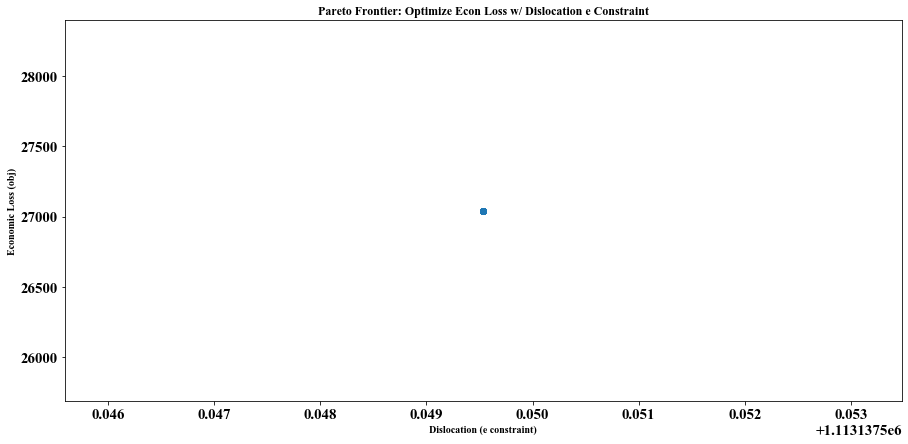

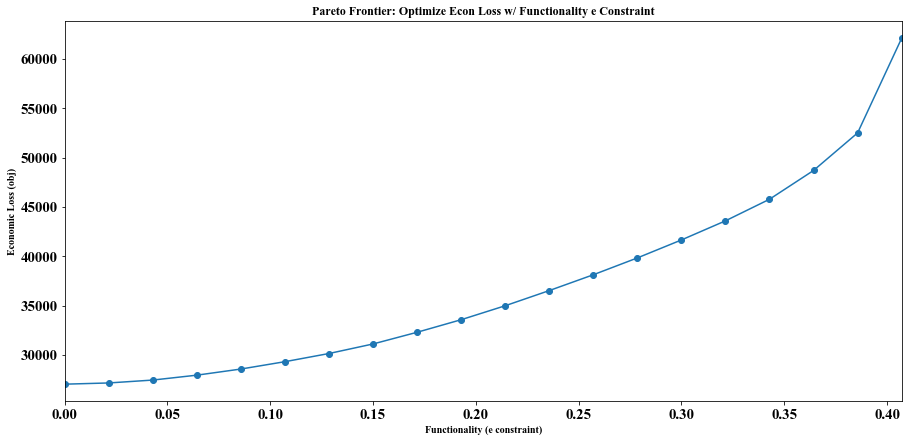

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning:

Attempting to set identical bottom == top == 1113137.549535661 results in singular transformations; automatically expanding.

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning:

Attempting to set identical left == right == 27042.744739878024 results in singular transformations; automatically expanding.



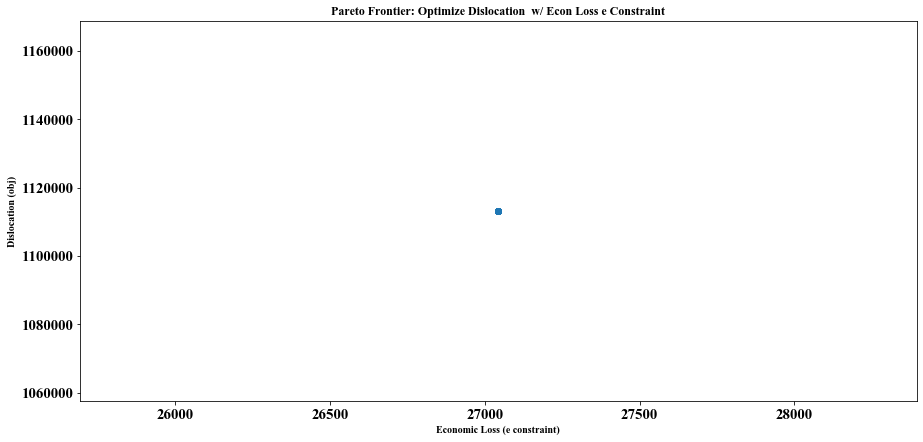

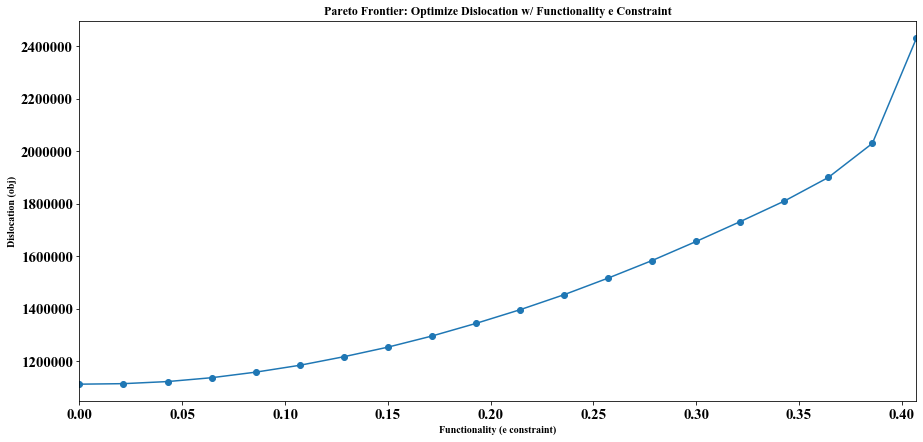

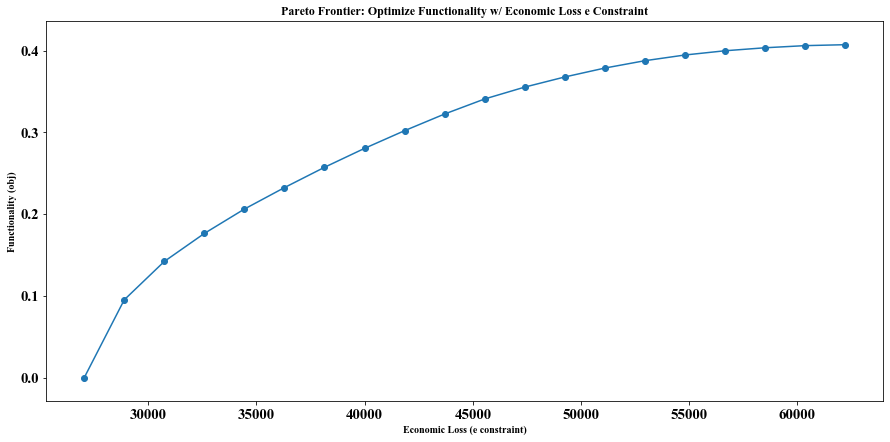

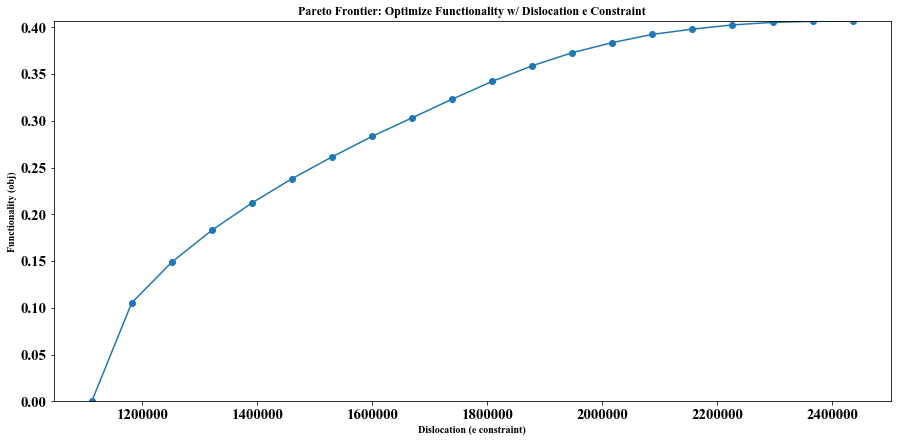

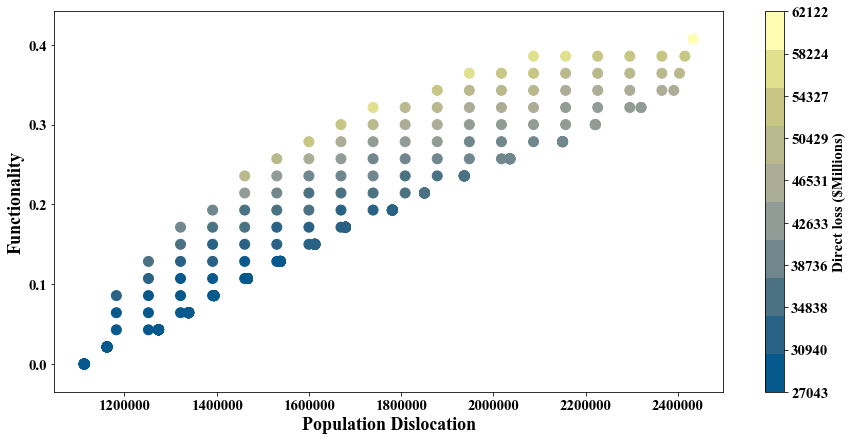

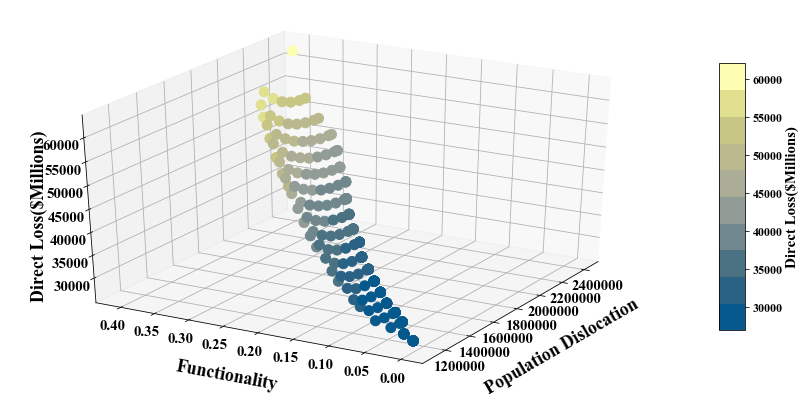

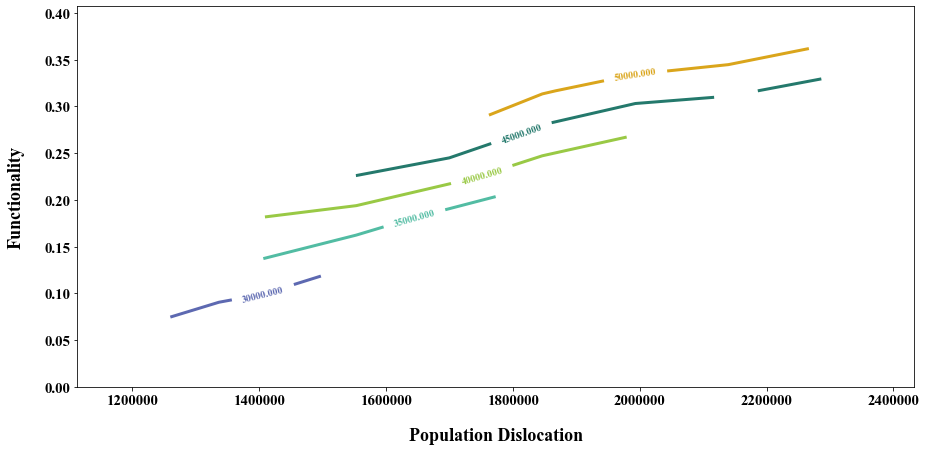

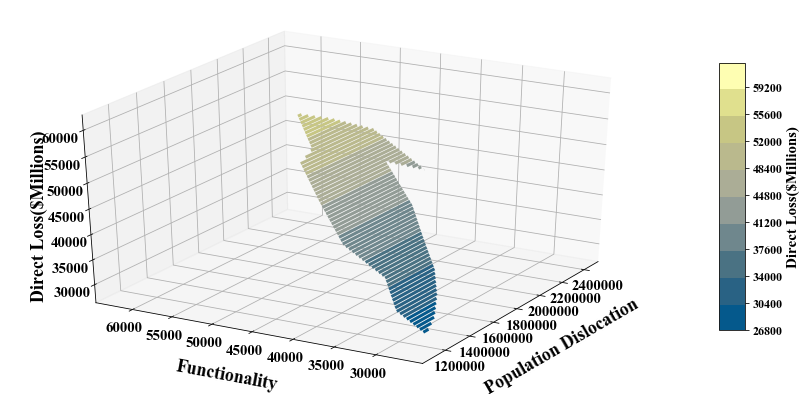

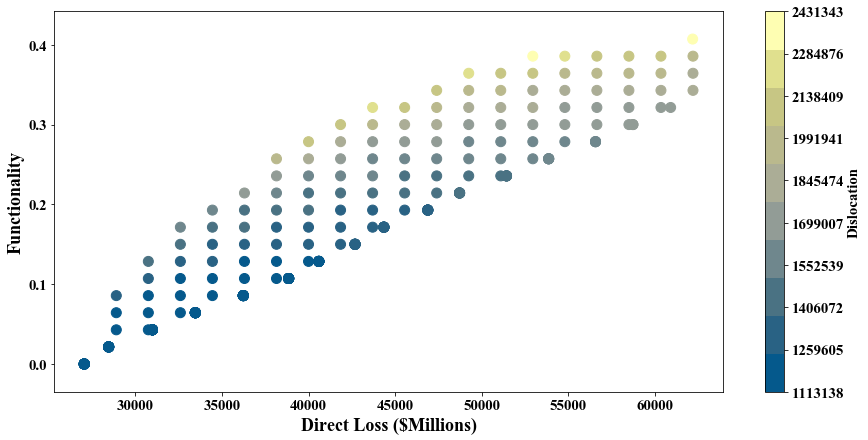

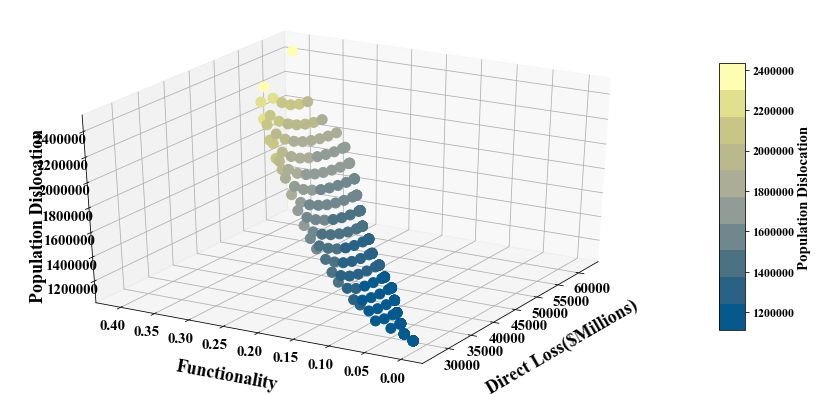

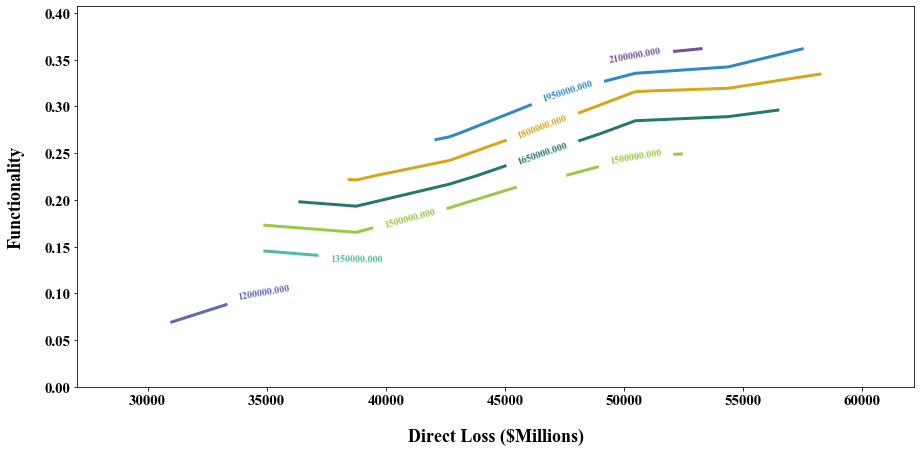

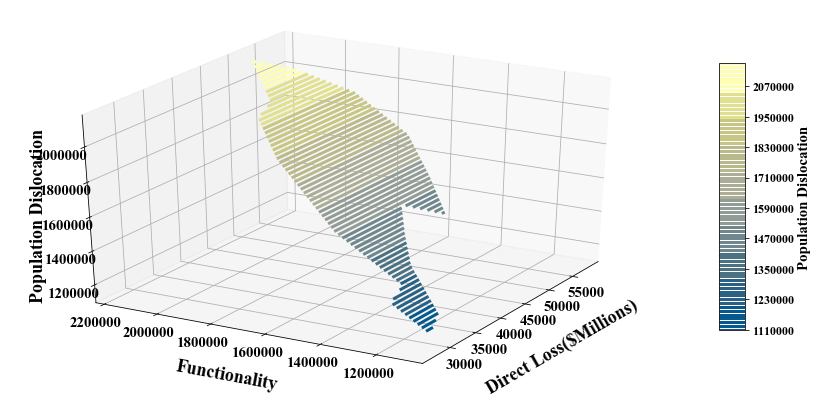

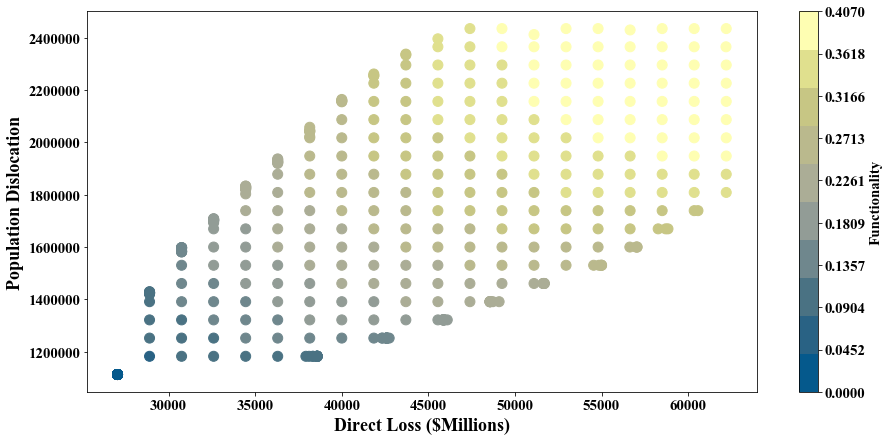

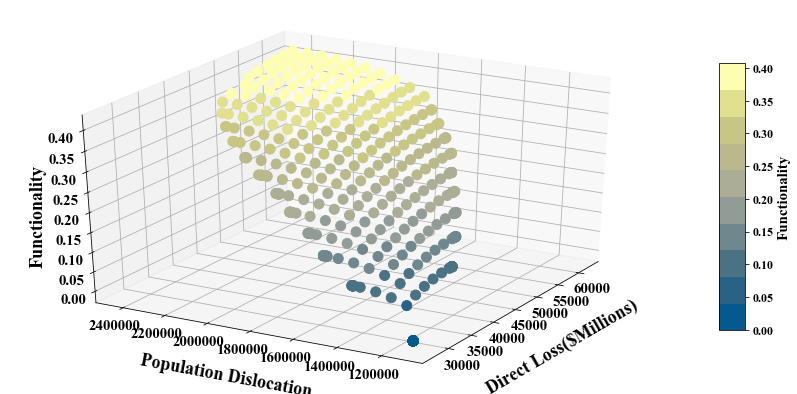

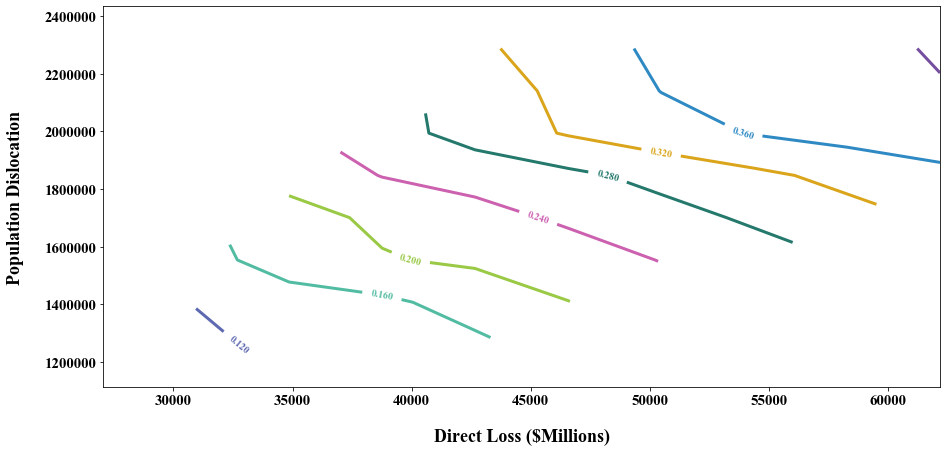

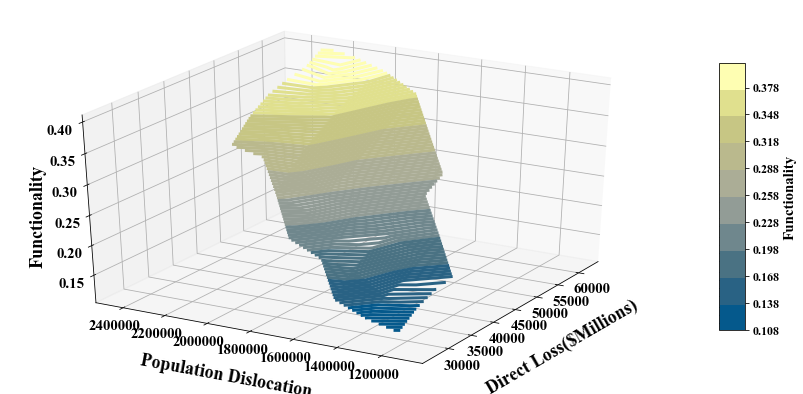

In [31]:
######################################################################################################
#GENERATE PLOTS OF MULTI-OBJECTIVE OPTIMIZATION RESULTS:
####################################################################################################
####################################################################################################


####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 1 WITH OBJECTIVE FUNCTION 2 AS CONSTRAINT:
####################################################################################################
if runModel1==1:
    fig=plt.figure(figsize=(15,7))
    plt.scatter(obj_1_2_epsilon_results['Dislocation Value'],obj_1_2_epsilon_results['Econ Loss Results'])
    plt.plot(obj_1_2_epsilon_results['Dislocation Value'],obj_1_2_epsilon_results['Econ Loss Results'])
    plt.ylim(min(obj_1_2_epsilon_results['Econ Loss Results']),max(obj_1_2_epsilon_results['Econ Loss Results']))
    plt.xlabel("Dislocation (e constraint)")
    plt.ylabel("Economic Loss (obj)")
    plt.title("Pareto Frontier: Optimize Econ Loss w/ Dislocation e Constraint")
    plt.show()
    filename='obj_1_2_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)


####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 1 WITH OBJECTIVE FUNCTION 3 AS CONSTRAINT:
####################################################################################################
if runModel2==1:
    fig=plt.figure(figsize=(15,7))
    plt.scatter(obj_1_3_epsilon_results['Functionality Value'],obj_1_3_epsilon_results['Econ Loss Results'])
    plt.plot(obj_1_3_epsilon_results['Functionality Value'],obj_1_3_epsilon_results['Econ Loss Results'])
    plt.xlim(min(obj_1_3_epsilon_results['Functionality Value'])-0.000001,max(obj_1_3_epsilon_results['Functionality Value'])+0.000001)
    plt.xlabel("Functionality (e constraint)")
    plt.ylabel("Economic Loss (obj)")
    plt.title("Pareto Frontier: Optimize Econ Loss w/ Functionality e Constraint")
    plt.show()
    filename='obj_1_3_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)


####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 2 WITH OBJECTIVE FUNCTION 1 AS CONSTRAINT:
####################################################################################################
if runModel3==1:
    fig=plt.figure(figsize=(15,7))
    plt.scatter(obj_2_1_epsilon_results['Econ Loss Value'],obj_2_1_epsilon_results['Dislocation Results'])
    plt.plot(obj_2_1_epsilon_results['Econ Loss Value'],obj_2_1_epsilon_results['Dislocation Results'])
    plt.ylim(min(obj_2_1_epsilon_results['Dislocation Results'])-0.0000000001,max(obj_2_1_epsilon_results['Dislocation Results'])+0.0000000001)
    plt.xlim(min(obj_2_1_epsilon_results['Econ Loss Value']),max(obj_2_1_epsilon_results['Econ Loss Value']))
    plt.xlabel("Economic Loss (e constraint)")
    plt.ylabel("Dislocation (obj)")
    plt.title("Pareto Frontier: Optimize Dislocation  w/ Econ Loss e Constraint")
    plt.show()
    filename='obj_2_1_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)


####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 2 WITH OBJECTIVE FUNCTION 3 AS CONSTRAINT:
####################################################################################################
if runModel4==1:
    fig=plt.figure(figsize=(15,7))
    plt.scatter(obj_2_3_epsilon_results['Functionality Value'],obj_2_3_epsilon_results['Dislocation Results'])
    plt.plot(obj_2_3_epsilon_results['Functionality Value'],obj_2_3_epsilon_results['Dislocation Results'])
    plt.xlim(min(obj_2_3_epsilon_results['Functionality Value'])-0.000001,max(obj_2_3_epsilon_results['Functionality Value']+0.000001))
    plt.xlabel("Functionality (e constraint)")
    plt.ylabel("Dislocation (obj)")
    plt.title("Pareto Frontier: Optimize Dislocation w/ Functionality e Constraint")
    plt.show()
    filename='obj_2_3_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)


####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 3 WITH OBJECTIVE FUNCTION 1 AS CONSTRAINT:
####################################################################################################
if runModel5==1:
    fig=plt.figure(figsize=(15,7))
    plt.scatter(obj_3_1_epsilon_results['Econ Loss Value'],obj_3_1_epsilon_results['Functionality Results'])
    plt.plot(obj_3_1_epsilon_results['Econ Loss Value'],obj_3_1_epsilon_results['Functionality Results'])
    plt.xlabel("Economic Loss (e constraint)")
    plt.ylabel("Functionality (obj)")
    plt.title("Pareto Frontier: Optimize Functionality w/ Economic Loss e Constraint")
    plt.show()
    filename='obj_3_1_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)


####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 3 WITH OBJECTIVE FUNCTION 2 AS CONSTRAINT:
####################################################################################################
if runModel6==1:
    fig=plt.figure(figsize=(15,7))
    plt.scatter(obj_3_2_epsilon_results['Dislocation Value'],obj_3_2_epsilon_results['Functionality Results'])
    plt.plot(obj_3_2_epsilon_results['Dislocation Value'],obj_3_2_epsilon_results['Functionality Results'])
    plt.ylim(min(obj_3_2_epsilon_results['Functionality Results'])-0.000001,max(obj_3_2_epsilon_results['Functionality Results']+0.000001))
    plt.xlabel("Dislocation (e constraint)")
    plt.ylabel("Functionality (obj)")
    plt.title("Pareto Frontier: Optimize Functionality w/ Dislocation e Constraint")
    plt.show()
    filename='obj_3_2_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)



####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 1 WITH OBJECTIVE FUNCTIONS 2/3 AS CONSTRAINTS:
####################################################################################################
if runModel7==1:
    #2D SCATTER PLOT:
    X = obj_1_23_data['Economic Loss Results (obj)']
    Y = obj_1_23_data['Dislocation Value']
    Z = obj_1_23_data['Functionality Value']
    cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)
    fig=plt.figure(figsize=(15,7))
    plt.scatter(Y,Z,c=X,cmap=cm1,s=100)
    # color bar setting
    v1 = np.linspace(min(X), max(X), 10, endpoint=True)
    norm = mpl.colors.BoundaryNorm(v1, cm1.N,clip=True)
    cb1 = plt.colorbar(ticks = v1)
    cb1.set_label(label='Direct loss ($Millions)',size=15)
    cb1.ax.tick_params(labelsize=15)
    plt.clim(min(X), max(X))
    plt.xlabel("Population Dislocation",fontsize = 18)
    plt.ylabel("Functionality",fontsize = 18)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
    filename='obj_1_23_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #3D SCATTER PLOT:
    ploty,plotz, = np.meshgrid(np.linspace(np.min(Y),np.max(Y),10),\
                           np.linspace(np.min(Z),np.max(Z),10))
    plotz = interp.griddata((Y,Z),X,(ploty,plotz),method='linear') 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(Y,Z,X,c = X, s = 100, alpha = 1, cmap =cm1)
    ax.set_xlabel('Population Dislocation',fontsize = 18,labelpad=20)
    ax.set_ylabel('Functionality',fontsize = 18,labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Direct Loss($Millions)',fontsize = 18,labelpad=5,rotation=90) 
    ax.view_init(30,210) # view the plot from different angle
    cb1=fig.colorbar(sc,shrink=0.7, aspect=10)
    cb1.set_label(label="Direct Loss($Millions)",size=15)
    cb1.ax.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.show()
    filename='obj_1_23_3D_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #CONTOUR PLOT:
    cm3 = mpl.colors.ListedColormap(palettable.cartocolors.qualitative.Vivid_10.mpl_colors)
    ploty,plotz, = np.meshgrid(np.linspace(np.min(Y),np.max(Y),10),\
                           np.linspace(np.min(Z),np.max(Z),10))
    plotx = interp.griddata((Y,Z),X,(ploty,plotz),method='linear') 
    fig = plt.figure(figsize=(15,7))
    contours = plt.contour(ploty, plotz, plotx,cmap=cm3,linewidths=3)
    # Display z values on contour lines
    plt.clabel(contours, inline=1, fontsize=10)
    plt.ylabel('Functionality',fontsize = 18,labelpad=20)
    plt.xlabel('Population Dislocation',fontsize = 18,labelpad=20)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
    filename='obj_1_23_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #3D CONTOUR PLOT:
    ploty,plotz, = np.meshgrid(np.linspace(np.min(Y),np.max(Y),10),\
                           np.linspace(np.min(Z),np.max(Z),10))
    plotz = interp.griddata((Y,Z),X,(ploty,plotz),method='linear') 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    sc=ax.contour3D(ploty,plotz,plotx,100,cmap=cm1,linewidths=3)
    ax.set_xlabel('Population Dislocation',fontsize = 18,labelpad=20)
    ax.set_ylabel('Functionality',fontsize = 18,labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Direct Loss($Millions)',fontsize = 18,labelpad=5,rotation=90) 
    ax.view_init(30,210) # view the plot from different angle
    cb1=fig.colorbar(sc,shrink=0.7, aspect=10)
    cb1.set_label(label="Direct Loss($Millions)",size=15)
    cb1.ax.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.show()
    filename='obj_1_23_3D_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    

####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 2 WITH OBJECTIVE FUNCTIONs 1/3 AS CONSTRAINTS:
####################################################################################################
if runModel8==1:
    #2D SCATTER PLOT:
    X = obj_2_13_data['Economic Loss Value']
    Y = obj_2_13_data['Dislocation Results (obj)']
    Z = obj_2_13_data['Functionality Value']
    cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)
    fig=plt.figure(figsize=(15,7))
    plt.scatter(X,Z,c=Y,cmap=cm1,s=100)
    # color bar setting
    v1 = np.linspace(min(Y), max(Y), 10, endpoint=True)
    norm = mpl.colors.BoundaryNorm(v1, cm1.N,clip=True)
    cb1 = plt.colorbar(ticks = v1)
    cb1.set_label(label='Dislocation',size=15)
    cb1.ax.tick_params(labelsize=15)
    plt.clim(min(Y), max(Y))
    plt.xlabel("Direct Loss ($Millions)",fontsize = 18)
    plt.ylabel("Functionality",fontsize = 18)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
    filename='obj_2_13_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #3D SCATTER PLOT:
    plotx,plotz, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Z),np.max(Z),10))
    plotz = interp.griddata((X,Z),Y,(plotx,plotz),method='linear') 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X,Z,Y,c = Y, s = 100, alpha = 1, cmap =cm1)
    ax.set_xlabel('Direct Loss($Millions)',fontsize = 18,labelpad=20)
    ax.set_ylabel('Functionality',fontsize = 18,labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Population Dislocation',fontsize = 18,labelpad=5,rotation=90) 
    ax.view_init(30,210) # view the plot from different angle
    cb1=fig.colorbar(sc,shrink=0.7, aspect=10)
    cb1.set_label(label="Population Dislocation",size=15)
    cb1.ax.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.show()
    filename='obj_2_13_3D_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #CONTOUR PLOT:
    cm3 = mpl.colors.ListedColormap(palettable.cartocolors.qualitative.Vivid_10.mpl_colors)
    plotx,plotz, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Z),np.max(Z),10))
    ploty = interp.griddata((X,Z),Y,(plotx,plotz),method='linear') 
    fig = plt.figure(figsize=(15,7))
    contours = plt.contour(plotx, plotz, ploty,cmap=cm3,linewidths=3)
    # Display z values on contour lines
    plt.clabel(contours, inline=1, fontsize=10)
    plt.ylabel('Functionality',fontsize = 18,labelpad=20)
    plt.xlabel('Direct Loss ($Millions)',fontsize = 18,labelpad=20)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
    filename='obj_2_13_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #3D CONTOUR PLOT:
    plotx,plotz, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Z),np.max(Z),10))
    plotz = interp.griddata((X,Z),Y,(plotx,plotz),method='linear') 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    sc=ax.contour3D(plotx,plotz,ploty,100,cmap=cm1,linewidths=3)
    ax.set_xlabel('Direct Loss($Millions)',fontsize = 18,labelpad=20)
    ax.set_ylabel('Functionality',fontsize = 18,labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Population Dislocation',fontsize = 18,labelpad=5,rotation=90) 
    ax.view_init(30,210) # view the plot from different angle
    cb1=fig.colorbar(sc,shrink=0.7, aspect=10)
    cb1.set_label(label="Population Dislocation",size=15)
    cb1.ax.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.show()
    filename='obj_2_13_3D_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    

####################################################################################################
#PLOTS - OBJECTIVE FUNCTION 3 WITH OBJECTIVE FUNCTIONS 1/2 AS CONSTRAINTS:
####################################################################################################
if runModel9==1:
    #2D SCATTER PLOT:
    X = obj_3_12_data['Economic Loss Value']
    Y = obj_3_12_data['Dislocation Value']
    Z = obj_3_12_data['Functionality Results (obj)']
    cm1 = mpl.colors.ListedColormap(palettable.scientific.sequential.Nuuk_10.mpl_colors)
    fig=plt.figure(figsize=(15,7))
    plt.scatter(X,Y,c=Z,cmap=cm1,s=100)
    # color bar setting
    v1 = np.linspace(min(Z), max(Z), 10, endpoint=True)
    norm = mpl.colors.BoundaryNorm(v1, cm1.N,clip=True)
    cb1 = plt.colorbar(ticks = v1)
    cb1.set_label(label='Functionality',size=15)
    cb1.ax.tick_params(labelsize=15)
    plt.clim(min(Z), max(Z))
    plt.xlabel("Direct Loss ($Millions)",fontsize = 18)
    plt.ylabel("Population Dislocation",fontsize = 18)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
    filename='obj_3_12_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #3D SCATTER PLOT:
    plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Y),np.max(Y),10))
    plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear') 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X,Y,Z,c = Z, s = 100, alpha = 1, cmap =cm1)
    ax.set_xlabel('Direct Loss($Millions)',fontsize = 18,labelpad=20)
    ax.set_ylabel('Population Dislocation',fontsize = 18,labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Functionality',fontsize = 18,labelpad=5,rotation=90) 
    ax.view_init(30,210) # view the plot from different angle
    cb1=fig.colorbar(sc,shrink=0.7, aspect=10)
    cb1.set_label(label="Functionality",size=15)
    cb1.ax.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.show()
    filename='obj_3_12_3D_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #CONTOUR PLOT:
    cm3 = mpl.colors.ListedColormap(palettable.cartocolors.qualitative.Vivid_10.mpl_colors)
    plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Y),np.max(Y),10))
    plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear') 
    fig = plt.figure(figsize=(15,7))
    contours = plt.contour(plotx, ploty, plotz,cmap=cm3,linewidths=3)
    # Display z values on contour lines
    plt.clabel(contours, inline=1, fontsize=10)
    plt.ylabel('Population Dislocation',fontsize = 18,labelpad=20)
    plt.xlabel('Direct Loss ($Millions)',fontsize = 18,labelpad=20)
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.show()
    filename='obj_3_12_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)
    
    
    #3D CONTOUR PLOT:
    plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),\
                           np.linspace(np.min(Y),np.max(Y),10))
    plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear') 
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111, projection='3d')
    sc=ax.contour3D(plotx,ploty,plotz,100,cmap =cm1,linewidths=3)
    ax.set_xlabel('Direct Loss($Millions)',fontsize = 18,labelpad=20)
    ax.set_ylabel('Population Dislocation',fontsize = 18,labelpad=20)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel('Functionality',fontsize = 18,labelpad=5,rotation=90) 
    ax.view_init(30,210) # view the plot from different angle
    cb1=fig.colorbar(sc,shrink=0.7, aspect=10)
    cb1.set_label(label="Functionality",size=15)
    cb1.ax.tick_params(labelsize=12)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.show()
    filename='obj_3_12_3D_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg'
    fig.savefig(filename)

    
    
####################################################################################################
#SAVE THE VISUALIZATIONS TO A ZIP FILE:
####################################################################################################
with zipfile.ZipFile(str(time.strftime("%m-%d-%Y"))+"_visualizations.zip","w",compression=zipfile.ZIP_DEFLATED) as zf:
    if runModel1==1:
        zf.write('obj_1_2_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel2==1:
        zf.write('obj_1_3_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel3==1:
        zf.write('obj_2_1_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel4==1:
        zf.write('obj_2_3_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel5==1:
        zf.write('obj_3_1_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel6==1:
        zf.write('obj_3_2_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel7==1:
        zf.write('obj_1_23_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_1_23_3D_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_1_23_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_1_23_3D_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel8==1:
        zf.write('obj_2_13_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_2_13_3D_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_2_13_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_2_13_3D_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
    if runModel9==1:
        zf.write('obj_3_12_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_3_12_3D_scatter_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_3_12_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg')
        zf.write('obj_3_12_3D_contour_'+str(time.strftime("%m-%d-%Y"))+'.jpg')